# **About**
This notebook documents my approach and learnings from participating in a Kaggle competition focused on predicting insurance premium amounts. The evaluation metric for this competition is **Root Mean Squared Logrithmic Error (RMSLE).** The dataset is split into **three parts: train, test, and an original dataset:**
* **Train:** **1.2 million** records
* **Test:** **800,000** records
* **Original:** **278,860** records

### **Goal**
The objective is to accurately predict the **`premium_amount`** for each policyholder, optimizing the model for **RMSLE**.

### **Challenges**
* **Missing Data:** Several features contain missing values, ranging from **2% to over 30%.**
* **Outliers:** Columns like **`annual_income`** and **`health_score`** contain **extreme values**. These values were retained as they likely reflect real-world variability across individuals.
* **Weak Correlation with Target Variable:** The dataset lacks strong linear relationships with the target variable. For instance, the highest observed correlation was just **0.047** between **`previous_claim`** and **`premium_amount`**, indicating minimal direct predictive power.

### **Approach**
To address these challenges and enhance model performance:

#### **Exploratory Data Analysis (EDA):** 
* Conducted in-depth analysis to understand feature distributions, identify outliers, and assess feature-target relationships.

#### **Feature Engineering:**

✅ Created interaction and ratio-based features to uncover deeper relationships between variables.

✅ Applied smoothed target encoding to categorical features and group-wise categorical combinations to enhance signal strength.

✅ For high-cardinality numerical features, performed quantile binning followed by target-based statistical aggregations.

#### **Handling Missing Values:** 
* Applied **median** imputation for numerical features and **mode** imputation for categorical features using **SimpleImputer** within each fold via **ColumnTransformer**, ensuring no data leakage during cross-validation.

#### **Cross-Validation Strategy:**
* Employed **5-fold cross-validation.**
* All feature engineering steps including missing value imputation, target encoding, and aggregation were performed within each fold to prevent data leakage.

### **Model**
* Implemented and trained a **LightGBM model** using the engineered feature set.
* Manually selected model hyperparameters through iterative experimentation and validation.

In [1]:
# Import Library    
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt 

from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer 
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error 
from xgboost import XGBRegressor  
from catboost import CatBoostRegressor
import lightgbm as lgb
from lightgbm import LGBMRegressor, early_stopping
from sklearn.model_selection import train_test_split, cross_val_score, KFold 
from sklearn.metrics import mean_squared_log_error, mean_squared_error, make_scorer
from category_encoders import TargetEncoder
import optuna

# Display numbers in standard notation
pd.set_option('display.float_format', '{:.2f}'.format) 

# Display all columns
pd.set_option('display.max_columns', None)

import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)  
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings('ignore')

In [2]:
# Read Train Data & Drop `id` 
train_df = pd.read_csv('/kaggle/input/playground-series-s4e12/train.csv')
train_df.drop('id', axis=1, inplace=True)

# Read Test Data & Drop `id`  
test_df = pd.read_csv('/kaggle/input/playground-series-s4e12/test.csv')

# Read Original Data 
original = pd.read_csv('/kaggle/input/insurance-premium-prediction/Insurance Premium Prediction Dataset.csv')       

In [3]:
print('Original: ', original.shape)  
print('Train: ', train_df.shape)
print('Test: ', test_df.shape) 

Original:  (278860, 20)
Train:  (1200000, 20)
Test:  (800000, 20)


In [4]:
train_df.head(5)

,Age,Gender,Annual Income,Marital Status,Number of Dependents,Education Level,Occupation,Health Score,Location,Policy Type,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Policy Start Date,Customer Feedback,Smoking Status,Exercise Frequency,Property Type,Premium Amount
0,19.00,Female,10049.00,Married,1.00,Bachelor's,Self-Employed,22.60,Urban,Premium,2.00,17.00,372.00,5.00,2023-12-23 15:21:39.134960,Poor,No,Weekly,House,2869.00
1,39.00,Female,31678.00,Divorced,3.00,Master's,NaN,15.57,Rural,Comprehensive,1.00,12.00,694.00,2.00,2023-06-12 15:21:39.111551,Average,Yes,Monthly,House,1483.00
2,23.00,Male,25602.00,Divorced,3.00,High School,Self-Employed,47.18,Suburban,Premium,1.00,14.00,NaN,3.00,2023-09-30 15:21:39.221386,Good,Yes,Weekly,House,567.00
3,21.00,Male,141855.00,Married,2.00,Bachelor's,NaN,10.94,Rural,Basic,1.00,0.00,367.00,1.00,2024-06-12 15:21:39.226954,Poor,Yes,Daily,Apartment,765.00
4,21.00,Male,39651.00,Single,1.00,Bachelor's,Self-Employed,20.38,Rural,Premium,0.00,8.00,598.00,4.00,2021-12-01 15:21:39.252145,Poor,Yes,Weekly,House,2022.00


# **Data Cleaning**

In [5]:
# Change column names to lower_case & replace space with underscore
train_df.columns = train_df.columns.str.replace(' ', '_').str.lower()
test_df.columns = test_df.columns.str.replace(' ', '_').str.lower()
original.columns = original.columns.str.replace(' ', '_').str.lower()

print('Original:\n', original.columns)
print('Train:\n', train_df.columns)
print('Test:\n', test_df.columns)

Original:
 Index(['age', 'gender', 'annual_income', 'marital_status',
       'number_of_dependents', 'education_level', 'occupation', 'health_score',
       'location', 'policy_type', 'previous_claims', 'vehicle_age',
       'credit_score', 'insurance_duration', 'premium_amount',
       'policy_start_date', 'customer_feedback', 'smoking_status',
       'exercise_frequency', 'property_type'],
      dtype='object')
Train:
 Index(['age', 'gender', 'annual_income', 'marital_status',
       'number_of_dependents', 'education_level', 'occupation', 'health_score',
       'location', 'policy_type', 'previous_claims', 'vehicle_age',
       'credit_score', 'insurance_duration', 'policy_start_date',
       'customer_feedback', 'smoking_status', 'exercise_frequency',
       'property_type', 'premium_amount'],
      dtype='object')
Test:
 Index(['id', 'age', 'gender', 'annual_income', 'marital_status',
       'number_of_dependents', 'education_level', 'occupation', 'health_score',
       'location'

In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1200000 entries, 0 to 1199999
Data columns (total 20 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   age                   1181295 non-null  float64
 1   gender                1200000 non-null  object 
 2   annual_income         1155051 non-null  float64
 3   marital_status        1181471 non-null  object 
 4   number_of_dependents  1090328 non-null  float64
 5   education_level       1200000 non-null  object 
 6   occupation            841925 non-null   object 
 7   health_score          1125924 non-null  float64
 8   location              1200000 non-null  object 
 9   policy_type           1200000 non-null  object 
 10  previous_claims       835971 non-null   float64
 11  vehicle_age           1199994 non-null  float64
 12  credit_score          1062118 non-null  float64
 13  insurance_duration    1199999 non-null  float64
 14  policy_start_date     1200000 non-

In [7]:
# Change Data type for `policy_start_date` in all three dataset
original['policy_start_date'] = pd.to_datetime(original['policy_start_date'])
train_df['policy_start_date'] = pd.to_datetime(train_df['policy_start_date'])
test_df['policy_start_date'] = pd.to_datetime(test_df['policy_start_date'])

### **We need to verify a few key aspects to ensure consistency:**

**Consistency in Columns:** Ensure all datasets have the same number of columns.

**Column Names and Data Types:** Confirm that column names and their data types match in all datasets.

**Categorical Variables:** There are several categorical variables, so we must verify that they have the same number of unique categories to maintain consistency. 

In [8]:
# Define function to check for missing columns
def check_missing_columns(dataset1, dataset2, name_1 = 'dataset1', name_2 = 'dataset2'):
    # Get column names
    dataset1_col = set(dataset1.columns)
    dataset2_col = set(dataset2.columns)
    
    # Find missing columns in each dataset
    missing_col_dataset_1 = dataset2_col - dataset1_col
    missing_col_dataset_2 = dataset1_col - dataset2_col

    # Output the result
    if not missing_col_dataset_1 and not missing_col_dataset_2:
        print(f'Both {name_1} and {name_2} datasets contains the same columns.')
    else:
        if missing_col_dataset_1:
            print(f'Comparing {name_1} & {name_2}: \nThe following columns are missing in {name_1} dataset \n', missing_col_dataset_1)
        if missing_col_dataset_2:
            print(f'Comparing {name_1} & {name_2}: \nThe following columns are missing in {name_2} dataset \n', missing_col_dataset_2)

# Compare both dataset to check for missing columns 
check_missing_columns(original, train_df, name_1 = 'original', name_2 = 'train_df')
print()
check_missing_columns(train_df, test_df, name_1 = 'train_df', name_2 = 'test_df')
print()
check_missing_columns(original, test_df, name_1 = 'original', name_2 = 'test_df')

Both original and train_df datasets contains the same columns.

Comparing train_df & test_df: 
The following columns are missing in train_df dataset 
 {'id'}
Comparing train_df & test_df: 
The following columns are missing in test_df dataset 
 {'premium_amount'}

Comparing original & test_df: 
The following columns are missing in original dataset 
 {'id'}
Comparing original & test_df: 
The following columns are missing in test_df dataset 
 {'premium_amount'}


In [9]:
# Compare data types between two dataset 
def compare_data_types(dataset1, dataset2, name_1 = 'dataset1', name_2 = 'dataset2'):
    """
    This function checks if the data types of common columns between two DataFrames match
    """
    # Both datasets have the same columns for comparison
    common_columns = dataset1.columns.intersection(dataset2.columns)
    dataset1 = dataset1[common_columns]
    dataset2 = dataset2[common_columns]
    
    # Extract data types for both DataFrames
    dtypes1 = dataset1.dtypes
    dtypes2 = dataset2.dtypes

    # Create DataFrame for comparing data types
    dtype_comparison = pd.DataFrame({f'{name_1}': dtypes1, f'{name_2}': dtypes2})

    # Compare data type: Identify columns with different data types
    dtype_mismatch = dtype_comparison[dtype_comparison[f'{name_1}'] != dtype_comparison[f'{name_2}']]

    # Compare data types between two datasets
    if dtype_mismatch.empty:
        print(f'Comparing between {name_1} & {name_2}: \nAll common columns have matching data types between {name_1} and {name_2}')
    else:
        print(f'Columns with differing data types between {name_1} and {name_2}: \n', dtype_mismatch)

compare_data_types(original, train_df, name_1 = 'original', name_2 = 'train_df')
print()
compare_data_types(train_df, test_df, name_1 = 'train_df', name_2 = 'test_df')
print()
compare_data_types(original, test_df, name_1 = 'original', name_2 = 'test_df') 

Columns with differing data types between original and train_df: 
                    original train_df
vehicle_age           int64  float64
insurance_duration    int64  float64

Comparing between train_df & test_df: 
All common columns have matching data types between train_df and test_df

Columns with differing data types between original and test_df: 
                    original  test_df
vehicle_age           int64  float64
insurance_duration    int64  float64


In [10]:
# Convert data types in original dataset 
original['insurance_duration'] = original['insurance_duration'].astype('float64')
original['vehicle_age'] = original['vehicle_age'].astype('float64')

compare_data_types(original, train_df, name_1 = 'original', name_2 = 'train_df')
print()
compare_data_types(original, test_df, name_1 = 'original', name_2 = 'test_df') 

Comparing between original & train_df: 
All common columns have matching data types between original and train_df

Comparing between original & test_df: 
All common columns have matching data types between original and test_df


In [11]:
# Check for duplicates in each dataset
print('Original:', original.duplicated().sum())
print('Train:', train_df.duplicated().sum())
print('Test:', test_df.duplicated().sum())

Original: 0
Train: 0
Test: 0


In [12]:
# Check for infinite values in the `premium_amount` column
train_df['premium_amount'].isin([np.inf, -np.inf]).any()       

False

In [13]:
# Extract all catgorical variables 
categorical = train_df.select_dtypes(include=['object']).columns.tolist()

# Extract all numerical variables
numerical = train_df.select_dtypes(include=['int64', 'float64']).columns.tolist()
numerical.remove('premium_amount')     

In [14]:
# Numerical Features
numerical 

['age',
 'annual_income',
 'number_of_dependents',
 'health_score',
 'previous_claims',
 'vehicle_age',
 'credit_score',
 'insurance_duration']

In [15]:
# Creat dictionary to hold unqiue categories for each categorical variable
cat_unique = {var: train_df[var].dropna().unique().tolist() for var in categorical}
cat_unique  

{'gender': ['Female', 'Male'],
 'marital_status': ['Married', 'Divorced', 'Single'],
 'education_level': ["Bachelor's", "Master's", 'High School', 'PhD'],
 'occupation': ['Self-Employed', 'Employed', 'Unemployed'],
 'location': ['Urban', 'Rural', 'Suburban'],
 'policy_type': ['Premium', 'Comprehensive', 'Basic'],
 'customer_feedback': ['Poor', 'Average', 'Good'],
 'smoking_status': ['No', 'Yes'],
 'exercise_frequency': ['Weekly', 'Monthly', 'Daily', 'Rarely'],
 'property_type': ['House', 'Apartment', 'Condo']}

In [16]:
# Check consistency of unique categories across dataset 
for var in categorical:
    original_unique = set(original[var].dropna().unique())
    train_unique = set(train_df[var].dropna().unique())
    test_unique = set(test_df[var].dropna().unique())

    # Check if the count of unique categories and the categories themselves match 
    if len(original_unique) == len(train_unique) == len(test_unique) and original_unique == train_unique == test_unique:
        print(f'✅ Categories for {var} have same count & matches across all datasets')
    elif len(original_unique) == len(train_unique) == len(test_unique):
        print(f'Categories for {var} have same count in all datasets but categories do not match excatly')
    else:
        print(f'Number of unique categories for {var} does not match across all datasets')           

✅ Categories for gender have same count & matches across all datasets
✅ Categories for marital_status have same count & matches across all datasets
✅ Categories for education_level have same count & matches across all datasets
✅ Categories for occupation have same count & matches across all datasets
✅ Categories for location have same count & matches across all datasets
✅ Categories for policy_type have same count & matches across all datasets
✅ Categories for customer_feedback have same count & matches across all datasets
✅ Categories for smoking_status have same count & matches across all datasets
✅ Categories for exercise_frequency have same count & matches across all datasets
✅ Categories for property_type have same count & matches across all datasets


# **Distribution Analysis of Categorical Variables**

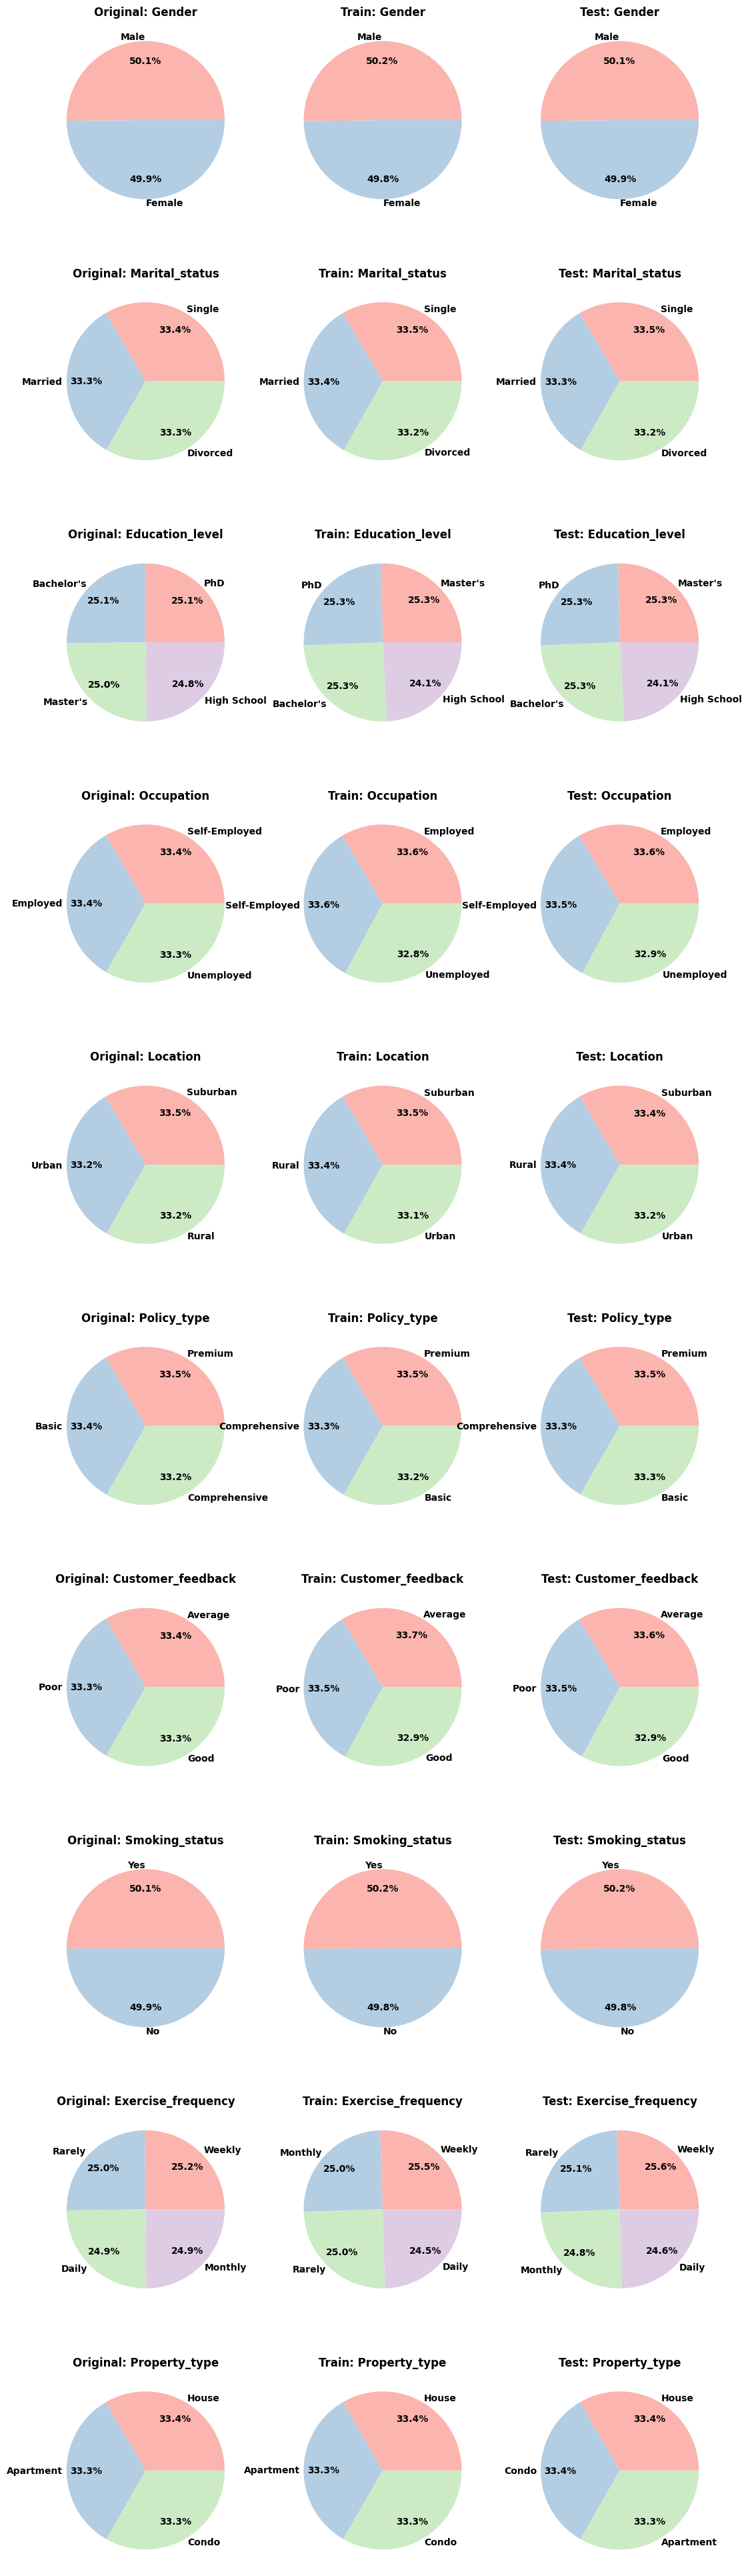

In [17]:
# Setup subplots
fig, axes = plt.subplots(len(categorical), 3, figsize = (13, 5 * len(categorical)))
        
# Create subplots
for i, var in enumerate(categorical):
    original_counts = original[var].value_counts()
    train_counts = train_df[var].value_counts()
    test_counts = test_df[var].value_counts()

    # Plot pie chart for original
    axes[i, 0].pie(original_counts,
                   labels = original_counts.index,
                   autopct = '%1.1f%%',
                   labeldistance = 1.05,
                   pctdistance = 0.75,
                   textprops = {'fontsize': 10, 'fontweight': 'bold'},
                   colors = plt.cm.Pastel1.colors)
    axes[i, 0].set_title(f'Original: {var.capitalize()}', weight = 'bold')

    # Plot pie chart for train_df
    axes[i, 1].pie(train_counts,
                   labels = train_counts.index,
                   autopct = '%1.1f%%',
                   labeldistance = 1.05,
                   pctdistance = 0.75,
                   textprops = {'fontsize': 10, 'fontweight': 'bold'},
                   colors = plt.cm.Pastel1.colors)
    axes[i, 1].set_title(f'Train: {var.capitalize()}', weight = 'bold')

    # Plot pie chart for test_df
    axes[i, 2].pie(test_counts,
                   labels = test_counts.index,
                   autopct = '%1.1f%%',
                   labeldistance = 1.05,
                   pctdistance = 0.75,
                   textprops = {'fontsize': 10, 'fontweight': 'bold'},
                   colors = plt.cm.Pastel1.colors)
    axes[i, 2].set_title(f'Test: {var.capitalize()}', weight = 'bold')

All categorical variables in the train, test, and original datasets exhibit balanced distributions. For example, the gender variable is nearly evenly split, with **50.1%** male and **49.9%** female. Similarly, other categorical variables also have a fairly even distribution across their unique categories.

# **Distribution Analysis of Numerical Variables**

In this section, we will examine and compare the distribution of numerical vaiables across the original, train, and test datasets. This analysis aims to:
- Ensure consistency in data distribution across the datasets.
- Identify any potential outliers.

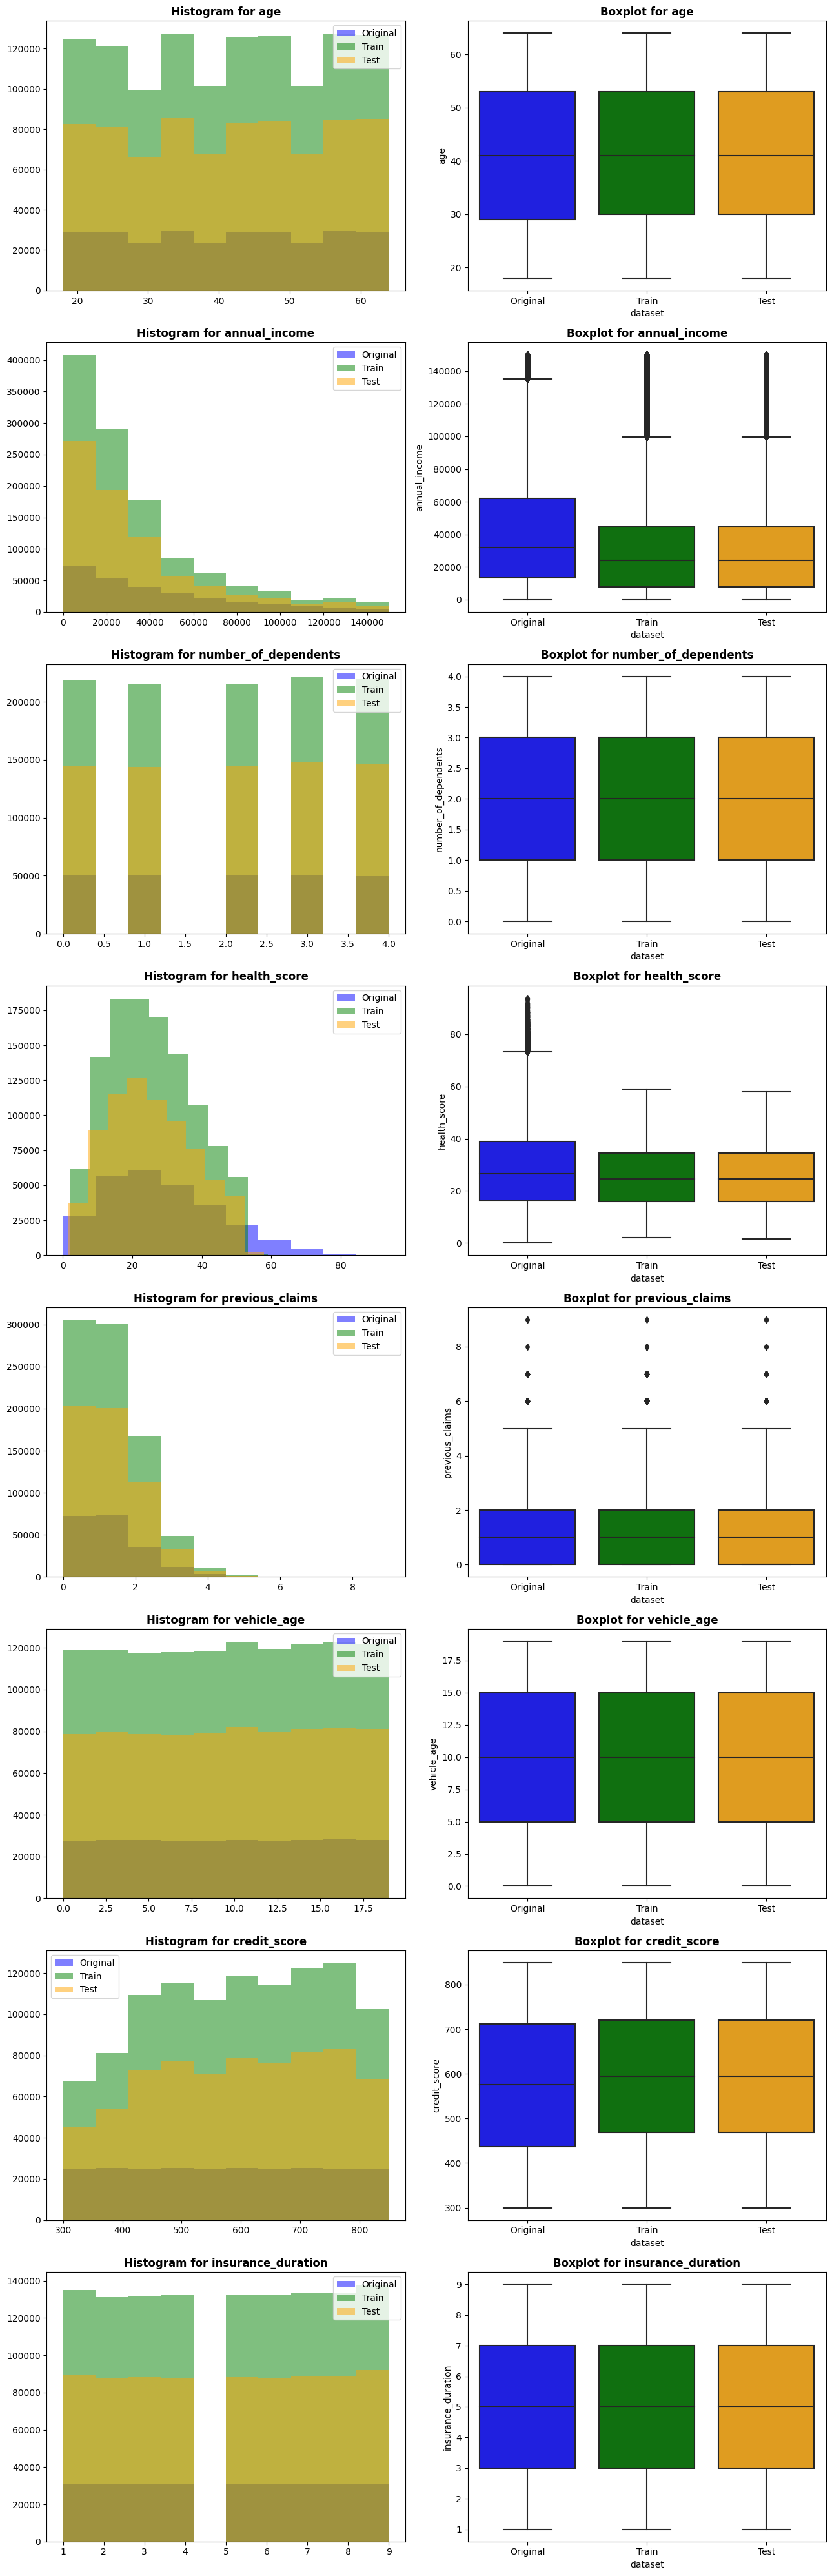

In [18]:
# Setup subplots
fig, axes = plt.subplots(len(numerical), 2, figsize = (13, 5 * len(numerical)))

# Color for datasets
palette = {'Original':'blue', 'Train':'green', 'Test':'orange'}

# Plot Histogram
for i, var in enumerate(numerical):
    axes[i, 0].hist(original[var], alpha=0.5, color=palette['Original'], label='Original')
    axes[i, 0].hist(train_df[var], alpha=0.5, color=palette['Train'], label='Train')
    axes[i, 0].hist(test_df[var], alpha=0.5, color=palette['Test'], label='Test')
    axes[i, 0].set_title(f'Histogram for {var}', weight='bold')
    axes[i, 0].legend()

    # Prepare data for boxplot 
    combined = pd.concat([original[var].to_frame().assign(dataset='Original'),
                         train_df[var].to_frame().assign(dataset='Train'),
                         test_df[var].to_frame().assign(dataset='Test')
                         ])
    # Plot Boxplot
    sns.boxplot(data=combined, x='dataset', y=var, ax=axes[i, 1], palette=palette)
    axes[i, 1].set_title(f'Boxplot for {var}', weight='bold')

plt.tight_layout()
plt.show() 

## **age, insurance_duration, vehicle_age, number_of_dependents**

In [19]:
print('Original Descriptive Stats:')  
print(original[['age', 'insurance_duration', 'vehicle_age', 'number_of_dependents']].describe().T)
print()
print('Train Descriptive Stats:')
print(train_df[['age', 'insurance_duration', 'vehicle_age', 'number_of_dependents']].describe().T)
print()
print('Test Descriptive Stats:')
print(test_df[['age', 'insurance_duration', 'vehicle_age', 'number_of_dependents']].describe().T)

Original Descriptive Stats:
                         count  mean   std   min   25%   50%   75%   max
age                  274175.00 41.02 13.55 18.00 29.00 41.00 53.00 64.00
insurance_duration   278860.00  5.01  2.58  1.00  3.00  5.00  7.00  9.00
vehicle_age          278860.00  9.52  5.77  0.00  5.00 10.00 15.00 19.00
number_of_dependents 250974.00  2.00  1.41  0.00  1.00  2.00  3.00  4.00

Train Descriptive Stats:
                          count  mean   std   min   25%   50%   75%   max
age                  1181295.00 41.15 13.54 18.00 30.00 41.00 53.00 64.00
insurance_duration   1199999.00  5.02  2.59  1.00  3.00  5.00  7.00  9.00
vehicle_age          1199994.00  9.57  5.78  0.00  5.00 10.00 15.00 19.00
number_of_dependents 1090328.00  2.01  1.42  0.00  1.00  2.00  3.00  4.00

Test Descriptive Stats:
                         count  mean   std   min   25%   50%   75%   max
age                  787511.00 41.14 13.54 18.00 30.00 41.00 53.00 64.00
insurance_duration   799998.00  5.02  2.

The shape of the data distribution in the histograms indicates that the distributions for all four variables - **`age`, `insurance_duration`, `vehicle_age`, and `number_of_dependents`** are similar across the three datasets. Boxplots show no outliers for these variables in any of the datasets. 

The descriptive statistics and boxplots suggest that the distributions of these variables are consistent across the three datasets. This consistency is reflected in the approximately similar means, medians, quartiles, minimums, and maximums, as well as the absence of outliers. 

## **credit_score and health_score**

In [20]:
print('Original Descriptive Stats:')
print(original[['credit_score', 'health_score']].describe())
print()
print('Train Descriptive Stats:')
print(train_df[['credit_score', 'health_score']].describe())
print()
print('Test Descriptive Stats:')
print(test_df[['credit_score', 'health_score']].describe())

Original Descriptive Stats:
       credit_score  health_score
count     250974.00     268263.00
mean         574.36         28.58
std          158.79         15.97
min          300.00          0.04
25%          437.00         16.15
50%          575.00         26.45
75%          712.00         38.97
max          849.00         93.88

Train Descriptive Stats:
       credit_score  health_score
count    1062118.00    1125924.00
mean         592.92         25.61
std          149.98         12.20
min          300.00          2.01
25%          468.00         15.92
50%          595.00         24.58
75%          721.00         34.53
max          849.00         58.98

Test Descriptive Stats:
       credit_score  health_score
count     708549.00     750551.00
mean         592.90         25.61
std          150.12         12.21
min          300.00          1.65
25%          468.00         15.92
50%          595.00         24.58
75%          721.00         34.52
max          849.00         57.96


The descriptive statistics for **`credit_score`** and **`health_score`** across the three datasets show similar patterns, with means, medians, quartiles, minimums, and maximums being quite close, though not identical. The boxplots for **`credit_score`** indicate no outliers in any of the datasets. 

However, the box for the original dataset is slightly larger than those for the train and test datasets, which are of equal size. This suggests that while the overall distribution of **`credit_score`** is consistent, the original dataset has a slightly wider spread of values compared to the train and test datasets. 

The credit scores in the train and test dataset are generally on the **lower side**, with a mean of **592** and a median of **595**. Descriptive statistics reveal that **75%** of individuals in this dataset have a credit score below **721**, further highlighting the **overall lower credit score distribution.**

For **`health_score`**, the histograms shows that the distribution is quite similar across the three datasets, with a **slightly longer tail** in the original dataset. The boxplot reveals that there are outliers in the **`health_score`** of the original dataset, while the train and test datasets do not have any outliers. 

## **annual_income and previous_claims**

In [21]:
print('Original Descriptive Stats:') 
print(original[['annual_income', 'previous_claims']].describe())
print()
print('Train Descriptive Stats:')
print(train_df[['annual_income', 'previous_claims']].describe())
print()
print('Test Descriptive Stats:')
print(test_df[['annual_income', 'previous_claims']].describe())  

Original Descriptive Stats:
       annual_income  previous_claims
count      264905.00        197572.00
mean        42089.09             1.00
std         35444.52             1.00
min             0.00             0.00
25%         13588.00             0.00
50%         32191.00             1.00
75%         62164.00             2.00
max        149997.00             9.00

Train Descriptive Stats:
       annual_income  previous_claims
count     1155051.00        835971.00
mean        32745.22             1.00
std         32179.51             0.98
min             1.00             0.00
25%          8001.00             0.00
50%         23911.00             1.00
75%         44634.00             2.00
max        149997.00             9.00

Test Descriptive Stats:
       annual_income  previous_claims
count      770140.00        557198.00
mean        32803.87             1.00
std         32201.06             0.98
min             2.00             0.00
25%          8048.00             0.00
50%      

The histogram shows that the distribution of **`annual_income`** is **right-skewed** for all the three datasets, with the shape being consistent across them. The boxplot reveals that the original dataset has a wider spread of values compared to the train and test datasets. Additionally, the boxplots indicate the presence of outliers in all datasets.

The boxplot of previous_claims reveals the presence of outliers across all three datasets. Descriptive statistics show that **75%** of policyholders have **two or fewer previous claims**, indicating that higher claim counts are relatively rare and may represent exceptional cases or outliers.

## **Analyzing the Target Variable - premium_amount**

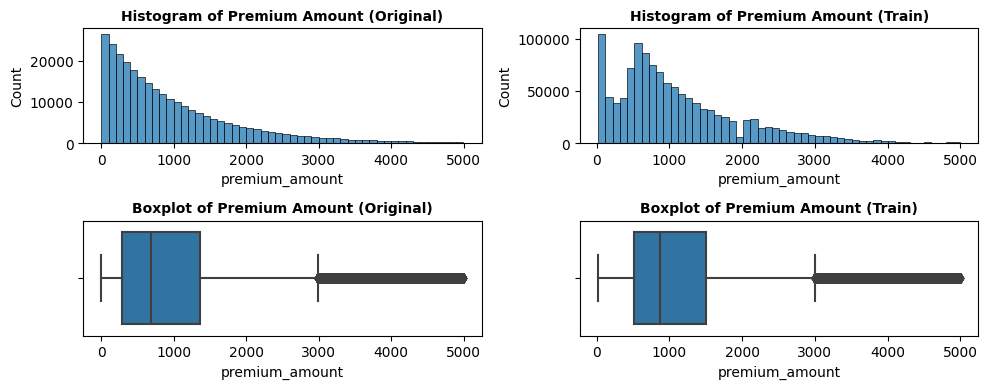

In [22]:
# Set subplots 
fig, axes = plt.subplots(2, 2, figsize=(10, 4)) 

# Histogram for the original dataset 
sns.histplot(original['premium_amount'], ax=axes[0, 0], kde=False, bins=50) 
axes[0, 0].set_title('Histogram of Premium Amount (Original)',fontsize=10, weight='bold') 

# Histogram for the train_df dataset 
sns.histplot(train_df['premium_amount'], ax=axes[0, 1], kde=False, bins=50) 
axes[0, 1].set_title('Histogram of Premium Amount (Train)', fontsize=10, weight='bold') 

# Boxplot for the original dataset 
sns.boxplot(x=original['premium_amount'], ax=axes[1, 0]) 
axes[1, 0].set_title('Boxplot of Premium Amount (Original)', fontsize=10, weight='bold') 

# Boxplot for the train_df dataset 
sns.boxplot(x=train_df['premium_amount'], ax=axes[1, 1]) 
axes[1, 1].set_title('Boxplot of Premium Amount (Train)', fontsize=10, weight='bold') 

# Adjust layout 
plt.tight_layout() 
plt.show()

In [23]:
print('Original Descriptive Stats:') 
print(original[['premium_amount']].describe())
print()
print('Train Descriptive Stats:')
print(train_df[['premium_amount']].describe())

Original Descriptive Stats:
       premium_amount
count       277019.00
mean           966.12
std            909.40
min              0.00
25%            286.00
50%            688.00
75%           1367.00
max           4999.00

Train Descriptive Stats:
       premium_amount
count      1200000.00
mean          1102.54
std            865.00
min             20.00
25%            514.00
50%            872.00
75%           1509.00
max           4999.00


The target variable **`premium_amount`** has a **right-skewed distribution** in both the original and train datasets. In the original dataset, the histogram shows a right-skewed distribution with **each bin decreasing in size**. In the train dataset, the distribution is also **right-skewed**, with a **slight peak between 600 and 700**. Outliers can be detected in the boxplots for both datasets.

# **Missing Value**

In [24]:
# Missing values in Original data  
original_count = original.isna().sum()
original_perct = round(original.isna().sum() / len(original) * 100, 2)

# Missing values in Train data
train_count = train_df.isna().sum()
train_perct = round(train_df.isna().sum() / len(train_df) * 100, 2)

# Missing values in Test data
test_count = test_df.isna().sum()
test_perct = round(test_df.isna().sum() / len(test_df) * 100, 2)

# Create a DataFrame for missing value summary for three datasets
missing_summary = pd.DataFrame({
    'original_count': original_count,
    'original_perct': original_perct,
    'train_count': train_count,
    'train_perct': train_perct,
    'test_count': test_count,
    'test_perct': test_perct
})

print('\n' + '='*85) 
print(f"{'SUMMARY OF MISSING VALUES ACROSS THREE DATASETS':^85}") 
print('='*85 + '\n')

missing_summary


                   SUMMARY OF MISSING VALUES ACROSS THREE DATASETS                   



,original_count,original_perct,train_count,train_perct,test_count,test_perct
age,4685.00,1.68,18705.00,1.56,12489.00,1.56
annual_income,13955.00,5.00,44949.00,3.75,29860.00,3.73
credit_score,27886.00,10.00,137882.00,11.49,91451.00,11.43
customer_feedback,18349.00,6.58,77824.00,6.49,52276.00,6.53
education_level,0.00,0.00,0.00,0.00,0.00,0.00
exercise_frequency,0.00,0.00,0.00,0.00,0.00,0.00
gender,0.00,0.00,0.00,0.00,0.00,0.00
health_score,10597.00,3.80,74076.00,6.17,49449.00,6.18
id,NaN,NaN,NaN,NaN,0.00,0.00
insurance_duration,0.00,0.00,1.00,0.00,2.00,0.00


The missing values across the three datasets reveals that the proportion of missing data ranges approximately from **2%** to **30%**. Importantly, the missing values percentages are consistent across all three datasets. While some features exhibit minimal or no missing values, others such as **`occupation`** and **`previous_claims`** have nearly **30%** missing data.

To effectively handle these missing values, it is essential to examine the missing value patterns. We need to determine whether these values are missing at random (MAR) or exibit correlation with other features. 

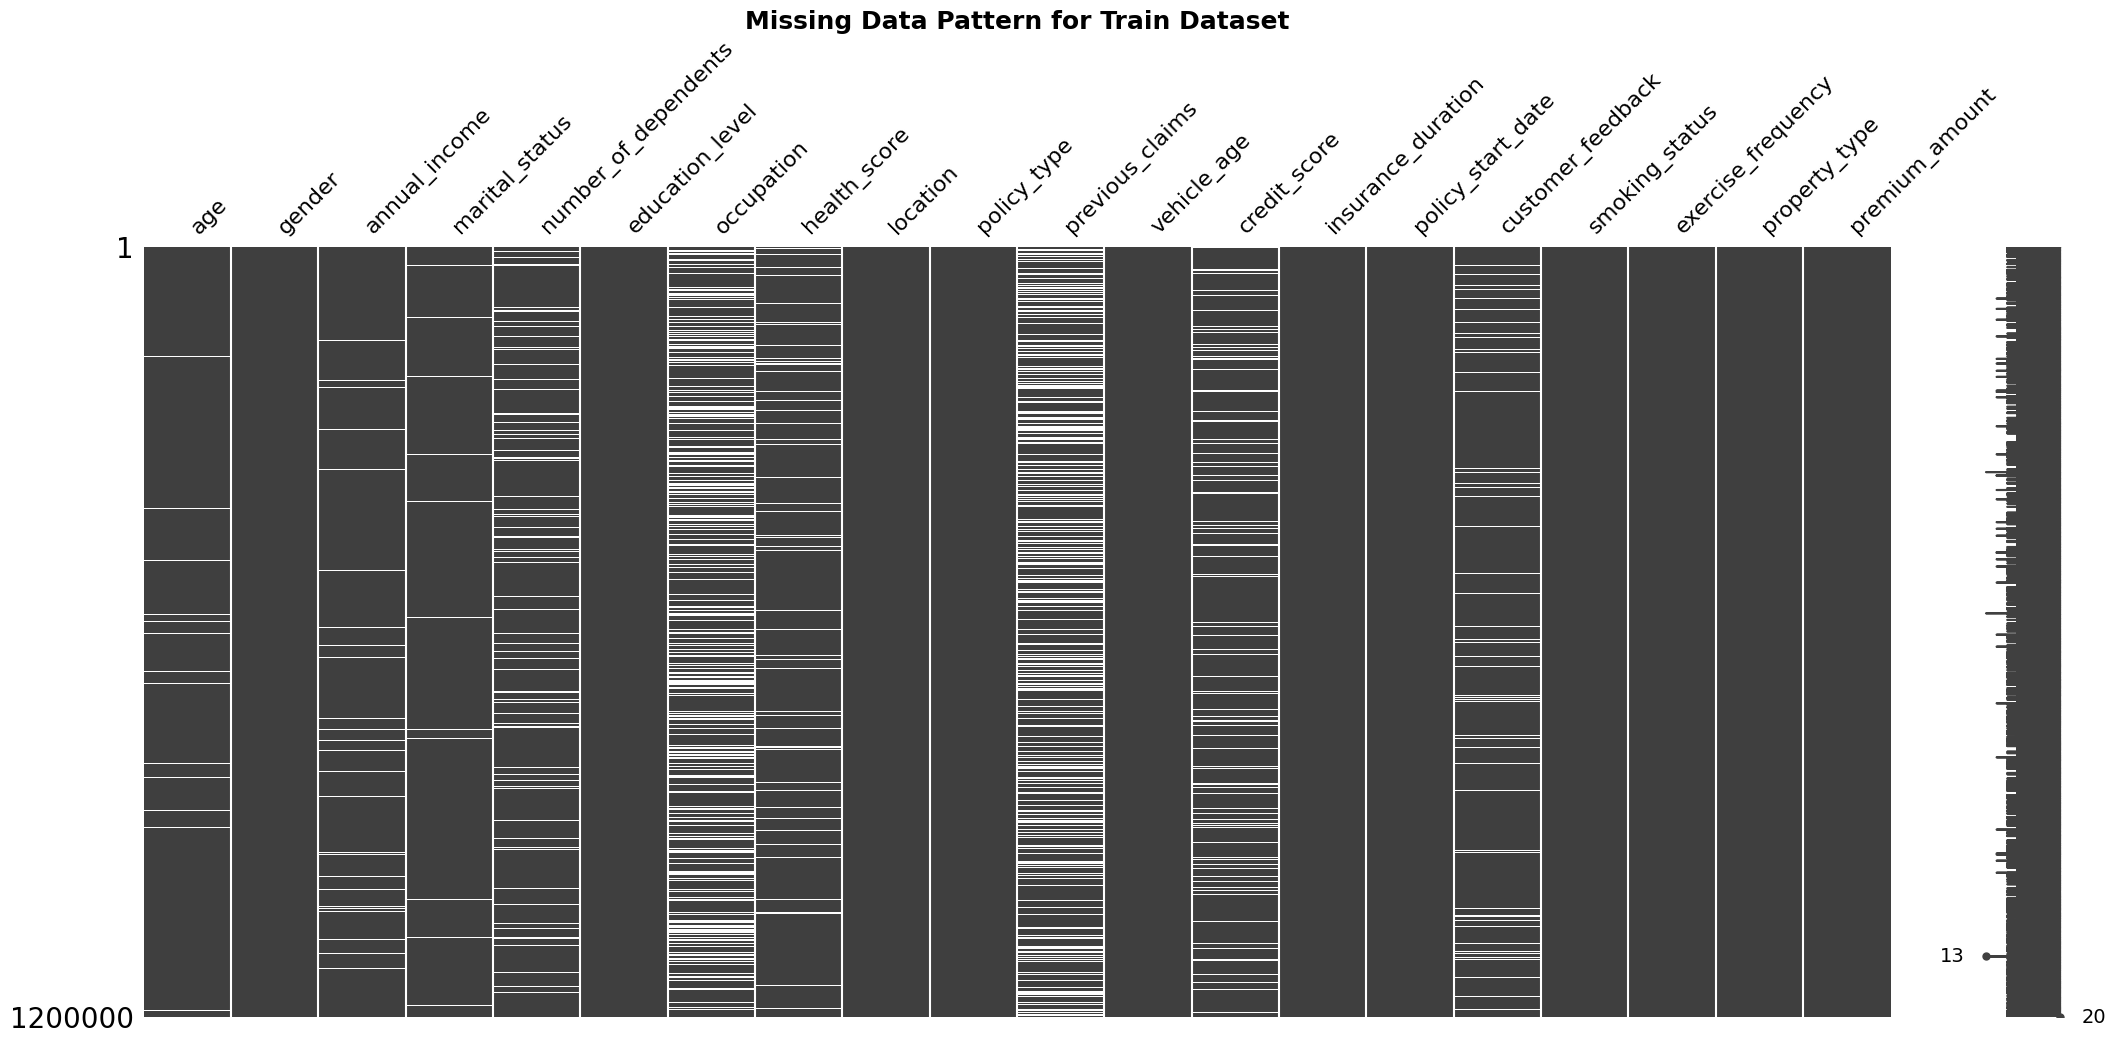

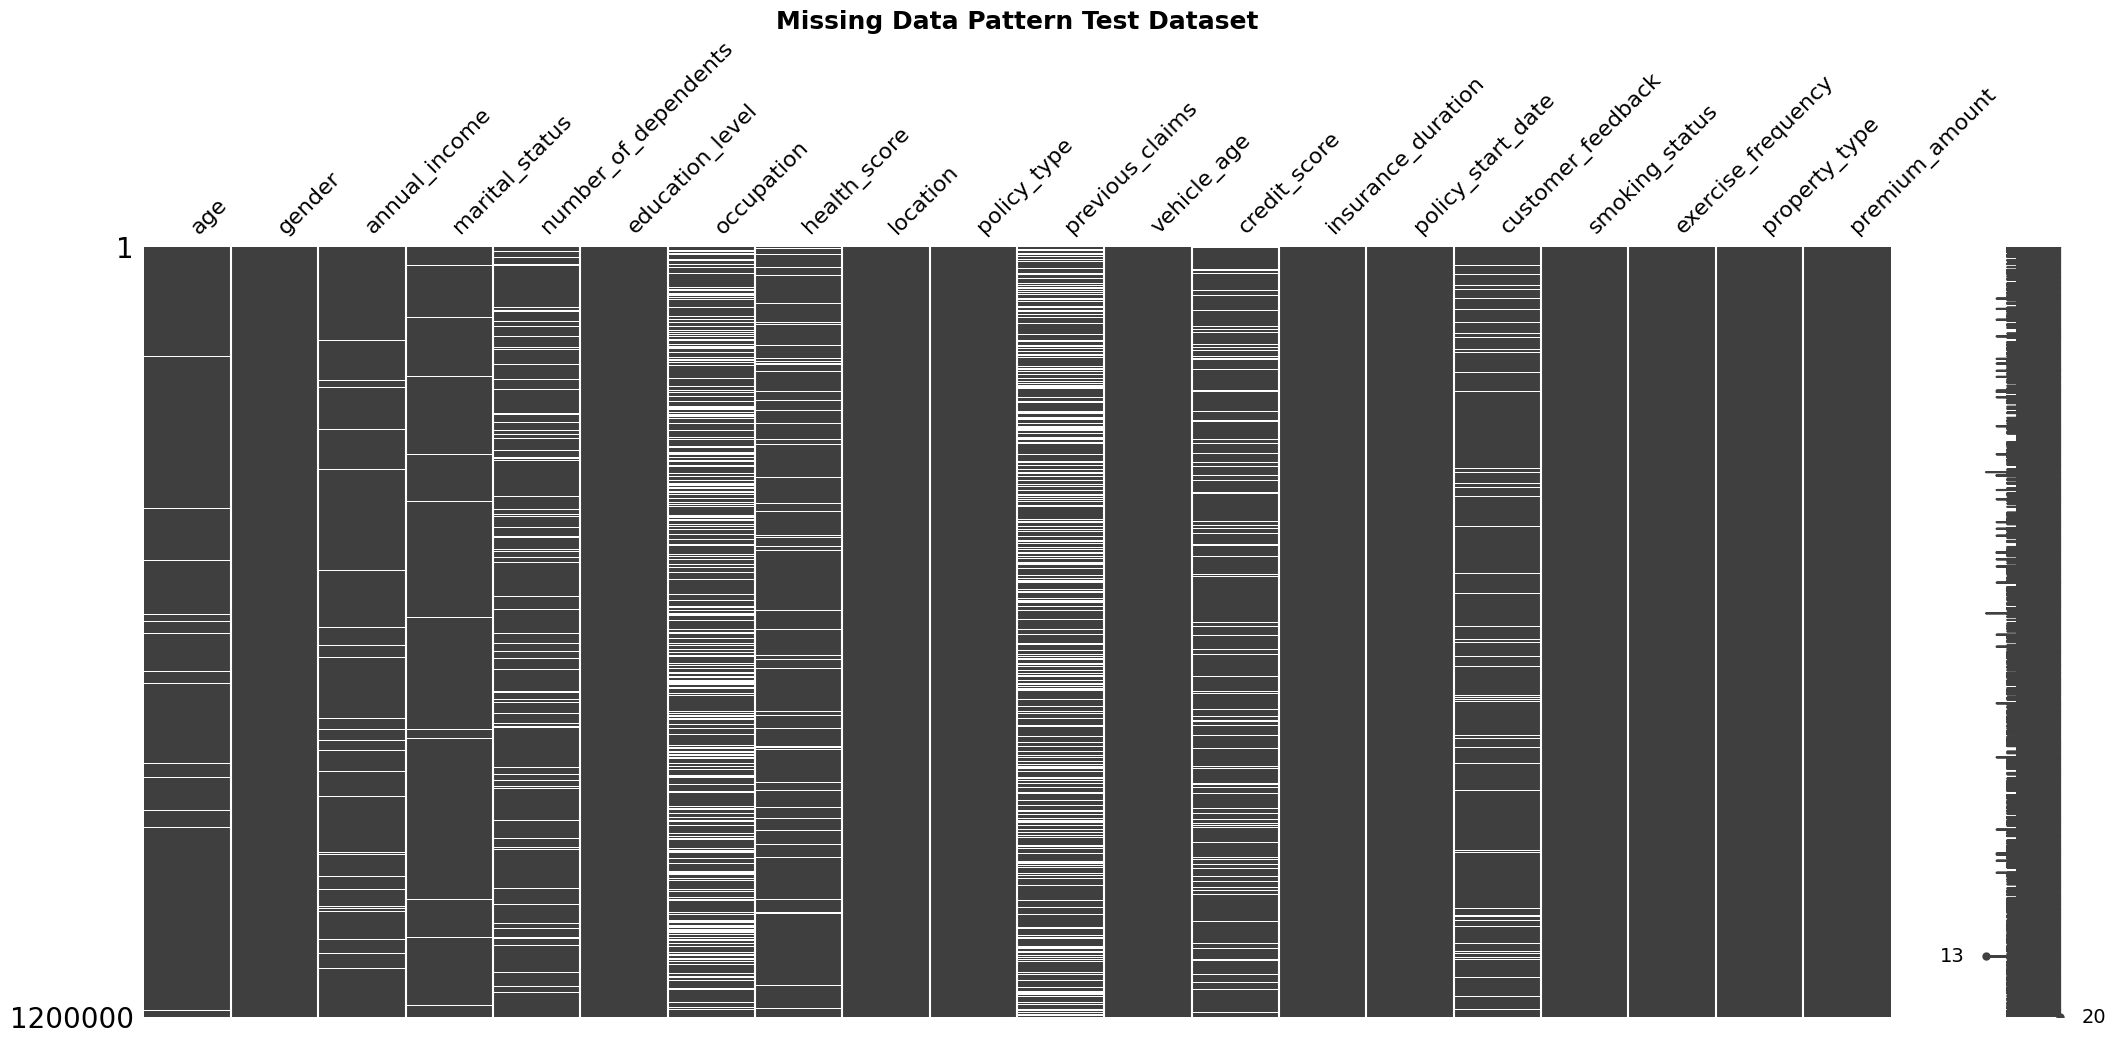

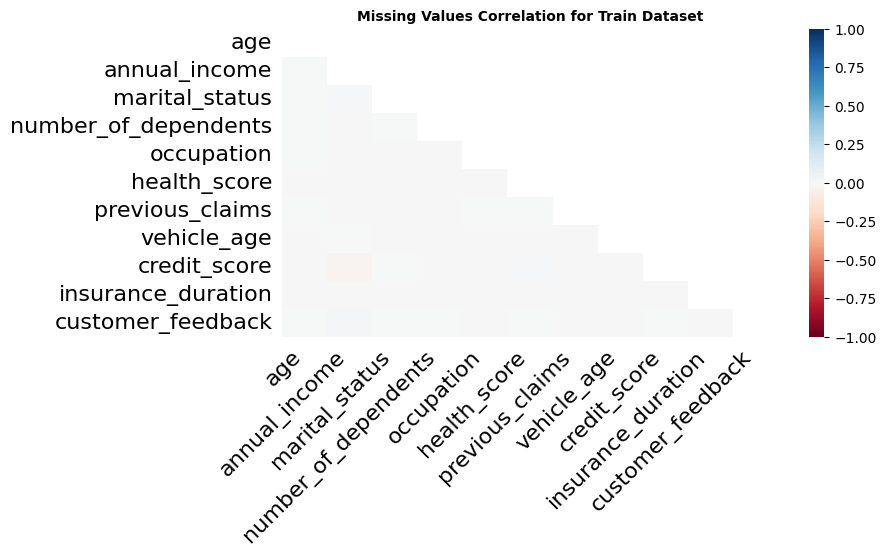

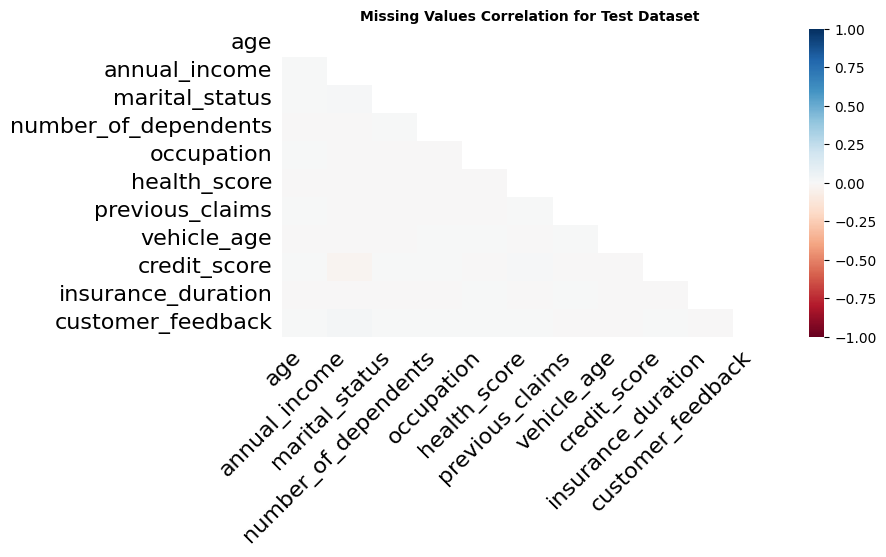

In [25]:
import missingno as msno

# Visualize missing data patterns
msno.matrix(train_df)
plt.title('Missing Data Pattern for Train Dataset', size=18, weight='bold')
plt.show()

msno.matrix(train_df)
plt.title('Missing Data Pattern Test Dataset', size=18, weight='bold')
plt.show()

# Visualize missing data correlations
msno.heatmap(train_df, figsize=(8, 4))
plt.title('Missing Values Correlation for Train Dataset', size=10, weight='bold')
plt.show()

msno.heatmap(test_df, figsize=(8, 4))
plt.title('Missing Values Correlation for Test Dataset', size=10, weight='bold')
plt.show()  

The **`msno.matrix`** visualization indicates that the missing values across all features in both datasets appear more random with no clear pattern. Features such as **`previous_claims`** and **`occupation`** have significant missing values, but these values are scattered randomly rather than being clustered together. This suggests that the missingness is more likely to be **Missing at Random (MAR)**, as there doesn't seem to be a specific trend. 

The **`msno.heatmap`** visualization shows white cells for all features, indicating no significant correlation between the missing values of different features. This indicates that the missing values are not correlated with each other. The missingness in one feature does not predict or depend on the missingness in another feature, further supporting the observation that the data is **Missing  at Random (MAR)**.

## **Concatenate Original & Train Datasets**

After analyzing the data distribution of both categorical and numerical features, I decided **not to concatenate** the original and train datasets. The shapes of the data distributions are consistent for each variable across all three datasets, as indicated by the histograms. However, the boxplots for few variables in the original dataset show wider values and outliers that are not present in the train and test datasets.

# **Correlation**

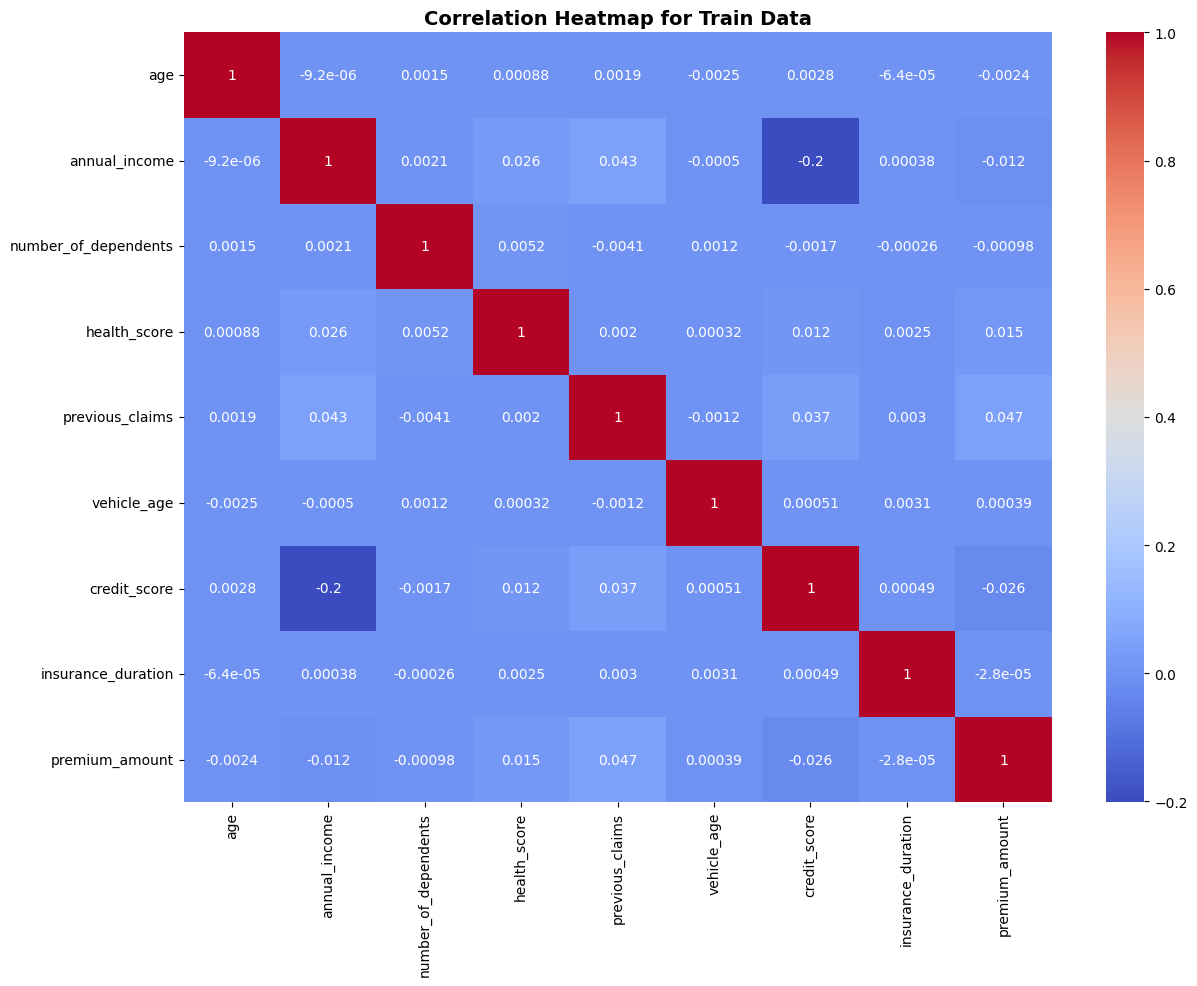

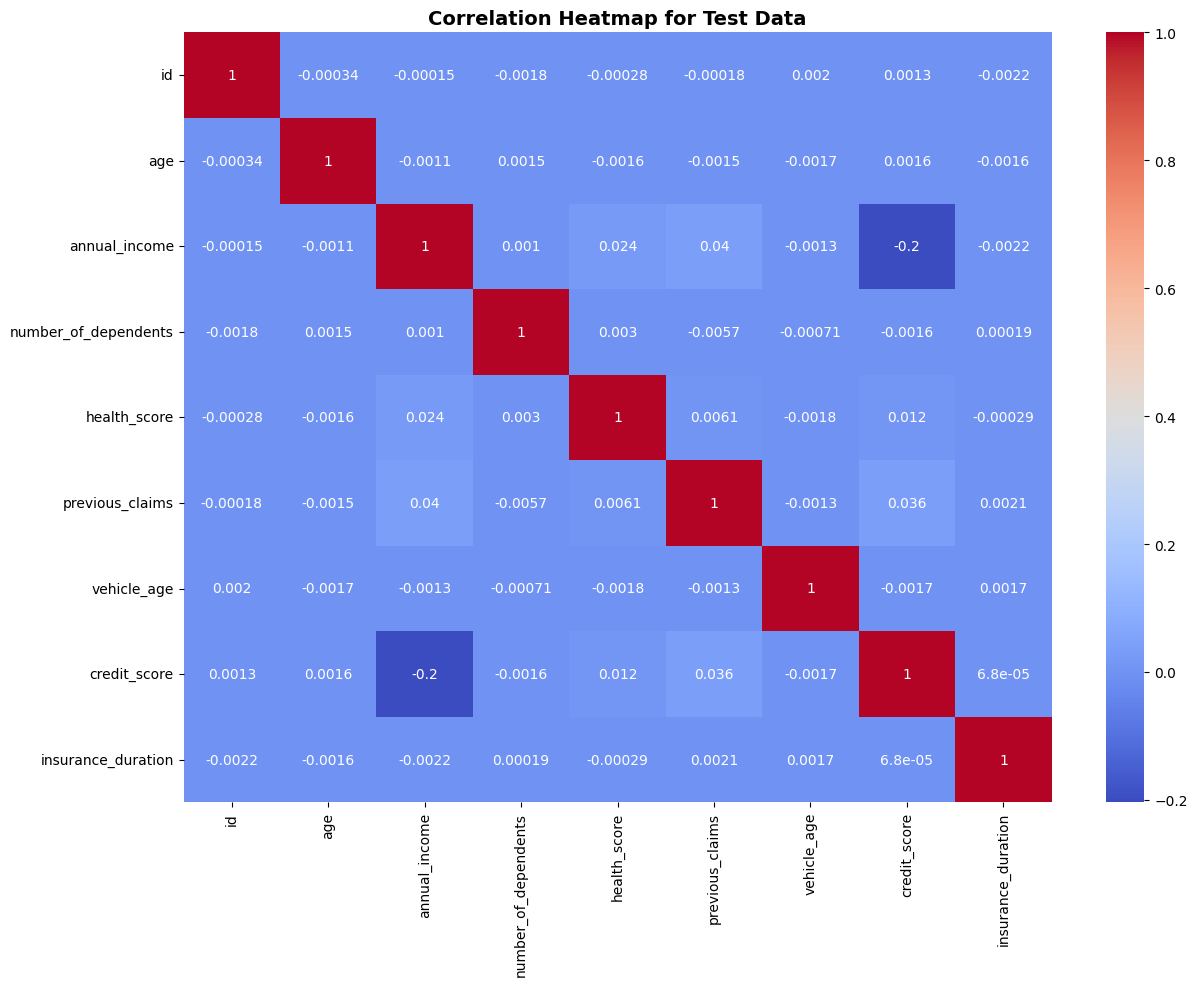

In [26]:
def heatmap(df, df_name):
    plt.figure(figsize=(14, 10))
    sns.heatmap(df.corr(method='pearson', numeric_only=True), annot=True, cmap='coolwarm')
    plt.title(f'Correlation Heatmap for {df_name} Data', fontsize=14, weight='bold')
    plt.show();

heatmap(train_df, 'Train')
heatmap(test_df, 'Test')

* The heatmap indicates that none of the features have a strong correlation with the target variable (**`premium_amount`**). **`previous_claims`** have a weak correlation of **0.047** with the **`premium_amount`** in the training dataset.
  
* **`credit_score`** and **`annual_income`** shows negative correlation coefficients of **-0.20** in both train and test dataset, indicating very weak relationship. The features do not show high correlation with the target variable (premium_amount), meaning linear relationships are weak or nonexistent.

# **Evaluating Premium Amount Trends by Various Factors**
By comparing premium amount trends across different factors such as property type, location, policy type, year, month, and previous claims, we can better understand their influence. This analysis can identify patterns and potential drivers of premium variations.

In [27]:
def boxplot(var):
    plt.figure(figsize=(8, 4))
    sns.boxplot(data=train_df, x=var, y='premium_amount', palette='Set2')
    plt.title(f'Boxplot of {var} vs premium_amount', size=12, weight='bold') 

## **Premium Amount by Property Type, Policy Type, and Location**

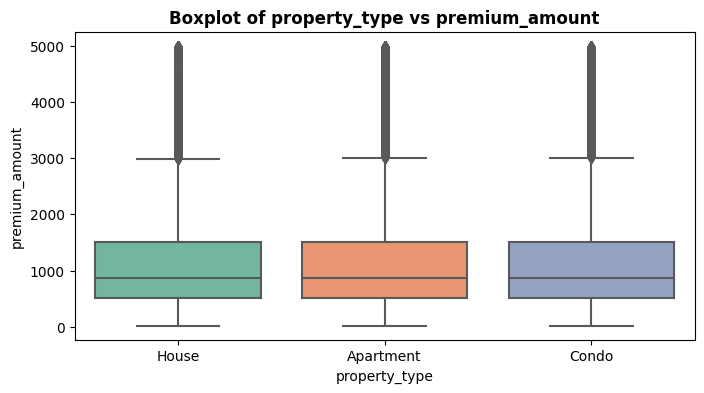

In [28]:
boxplot('property_type')

In [29]:
# Descriptive Statistics of `premium_amount` by `property_type`
train_df.groupby('property_type')['premium_amount'].describe()   

,count,mean,std,min,25%,50%,75%,max
property_type,,,,,,,,
Apartment,399978.00,1104.15,866.98,20.00,514.00,872.00,1512.00,4997.00
Condo,399673.00,1101.92,865.96,20.00,513.00,871.00,1512.00,4997.00
House,400349.00,1101.56,862.06,20.00,514.00,873.00,1505.00,4999.00


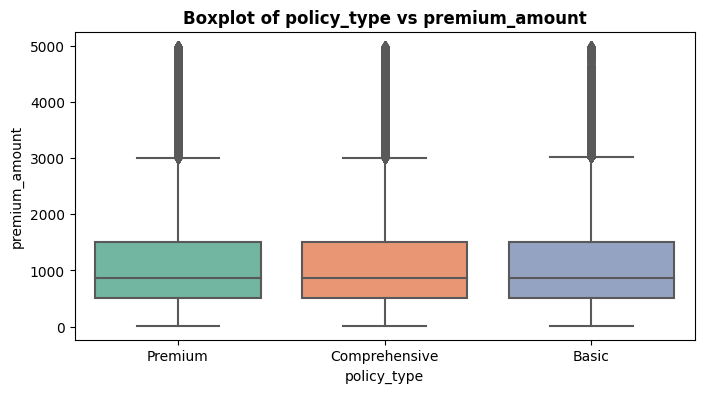

In [30]:
boxplot('policy_type')

In [31]:
# Descriptive Statistics of `premium_amount` by `policy_type`
train_df.groupby('policy_type')['premium_amount'].describe() 

,count,mean,std,min,25%,50%,75%,max
policy_type,,,,,,,,
Basic,398554.00,1103.45,864.86,20.00,514.00,874.00,1513.00,4999.00
Comprehensive,399600.00,1102.61,864.87,20.00,514.00,873.00,1507.00,4992.00
Premium,401846.00,1101.58,865.26,20.00,514.00,870.00,1508.00,4997.00


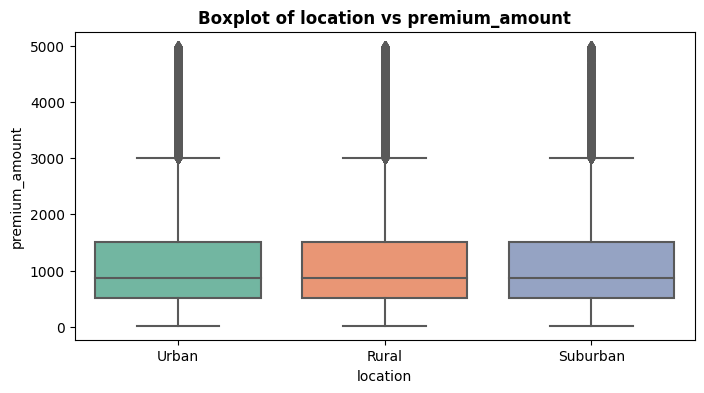

In [32]:
boxplot('location')

In [33]:
# Descriptive Statistics of `premium_amount` by `location`
train_df.groupby('location')['premium_amount'].describe()  

,count,mean,std,min,25%,50%,75%,max
location,,,,,,,,
Rural,400947.00,1101.47,865.06,20.00,514.00,871.00,1508.00,4997.00
Suburban,401542.00,1102.46,865.25,20.00,513.00,871.00,1509.00,4988.00
Urban,397511.00,1103.71,864.68,20.00,515.00,874.00,1509.00,4999.00


* The descriptive statistics indicate that the premium amounts for different **property_types** (Apartment, Condo, and House) are quite similar. The means and standard deviations are almost identical, and the minimum, 25%, 50% (median), 75%, and maximum values are also very close to each other. This indicates that there is no significant difference in the premium amount across different property types within this dataset.

* The boxplots for the property type exhibit a **consistent box size**, suggesting a relatively stable distribution of premium amounts across categories. However, the **presence of outliers** in each category indicates that some individuals have exceptionally high premiums compared to the majority. These outliers are common in real-world insurance data, where premium amounts are influenced by multiple complex factors beyond the visible categorical attributes.

* This pattern extends to **location** and **policy_types**, suggesting that premium amounts do not significantly vary based on these factors within this dataset. It implies that these factors may not be influential in determining the premium amount.

## **Premium Amount by Year**

In [34]:
def temporal(df):
    # Extract temporal features from `policy_start_date` 
    df['year'] = df['policy_start_date'].dt.year
    df['month'] = df['policy_start_date'].dt.month

temporal(train_df)
temporal(test_df)

# Descriptive Statistics of `premium_amount` by `year`
train_df.groupby('year')['premium_amount'].describe() 

,count,mean,std,min,25%,50%,75%,max
year,,,,,,,,
2019,84289.00,1189.56,914.40,20.00,536.00,944.00,1673.00,4988.00
2020,242087.00,1096.65,859.03,20.00,514.00,866.00,1497.00,4997.00
2021,244918.00,1093.35,858.52,20.00,514.00,861.00,1488.00,4997.00
2022,245671.00,1091.74,854.51,20.00,514.00,861.00,1486.00,4999.00
2023,239067.00,1094.55,862.63,20.00,508.00,867.00,1497.00,4988.00
2024,143968.00,1108.88,875.04,20.00,508.00,874.00,1520.00,4988.00


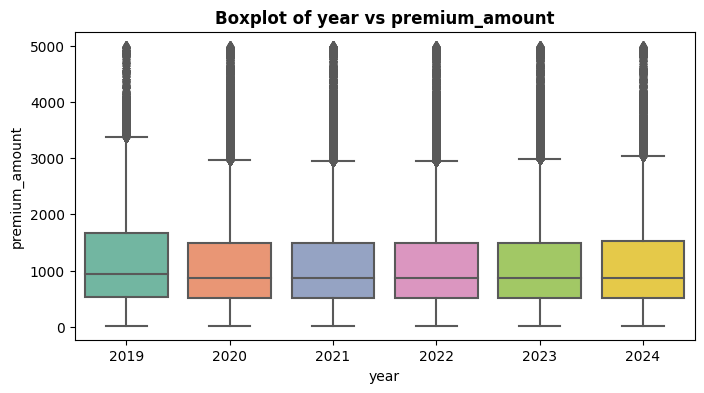

In [35]:
boxplot('year')

The analysis of **premium_amount** by year shows slight variations. While the means, medians, and standard deviations are fairly consistent, there are observable differences. In **2019**, the mean **(1189.56)**, median **(944)**, and standard deviation **(914.40)** are the highest. From **2020 to 2024**, the values are more consistent.

While average premiums didn't change drastically year-to-year, outliers indicate that extreme premium values continue to exist in all years. These might reflect rare high-risk cases or premium for high-value policies. Although the variations are not drastic, they suggest there might be some yearly influence on premium amounts.

## **Premium Amount by Months**

In [36]:
# Descriptive Statistics of `premium_amount` by `month`
train_df.groupby('month')['premium_amount'].describe()

,count,mean,std,min,25%,50%,75%,max
month,,,,,,,,
1,98535.00,1097.21,861.88,20.00,513.00,864.00,1497.00,4996.00
2,95924.00,1100.23,867.66,20.00,511.00,863.00,1507.00,4982.00
3,102909.00,1098.97,861.60,20.00,515.00,872.00,1498.00,4988.00
4,100906.00,1093.63,856.79,20.00,513.00,867.00,1494.00,4983.00
5,105176.00,1093.30,856.95,20.00,513.00,861.00,1490.00,4988.00
6,98500.00,1099.53,861.06,20.00,513.00,870.00,1512.00,4997.00
7,100772.00,1095.14,860.54,20.00,514.00,861.00,1489.00,4997.00
8,101077.00,1103.25,867.95,20.00,513.00,872.00,1506.00,4988.00
9,99377.00,1113.86,873.11,20.00,515.00,885.00,1526.00,4988.00


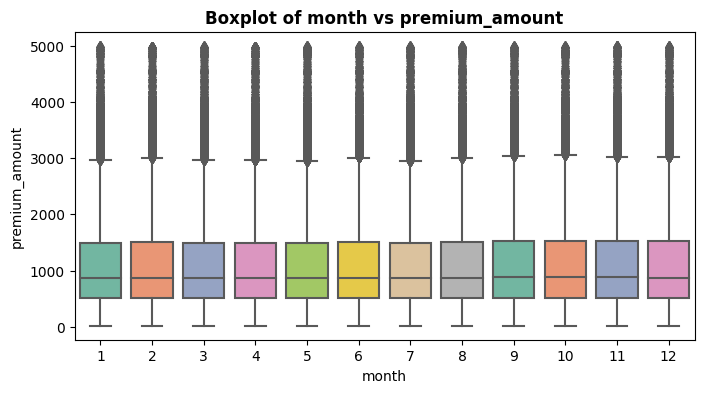

In [37]:
boxplot('month')

The analysis of **premium_amount** by months **shows slight variations**. While the mean, median, and standard deviations are fairly consistent, there are some observable differences. Minor variations suggest that there might be some monthly influence on premium amounts, but the overall impact appears to be minimal.

## **Premium Amount by Previous Claims**

In [38]:
# Descriptive Statistics of `premium_amount` by `previous_claims`
train_df.groupby('previous_claims')['premium_amount'].describe()

,count,mean,std,min,25%,50%,75%,max
previous_claims,,,,,,,,
0.00,305433.00,1083.01,857.42,20.00,496.00,852.00,1479.00,4999.00
1.00,300811.00,1092.00,860.51,20.00,508.00,861.00,1489.00,4988.00
2.00,167661.00,1172.25,891.52,20.00,551.00,930.00,1616.00,4988.00
3.00,49011.00,1202.66,903.17,20.00,562.00,964.00,1658.00,4988.00
4.00,10668.00,1242.40,917.54,20.00,566.00,1010.00,1730.25,4982.00
5.00,2018.00,1239.52,927.94,20.00,573.25,990.00,1749.25,4988.00
6.00,302.00,1334.13,986.52,20.00,582.75,1113.00,1870.00,4955.00
7.00,58.00,1483.24,1007.29,54.00,711.50,1205.50,2143.00,4093.00
8.00,8.00,1298.00,925.22,63.00,777.25,1177.50,1737.25,3042.00


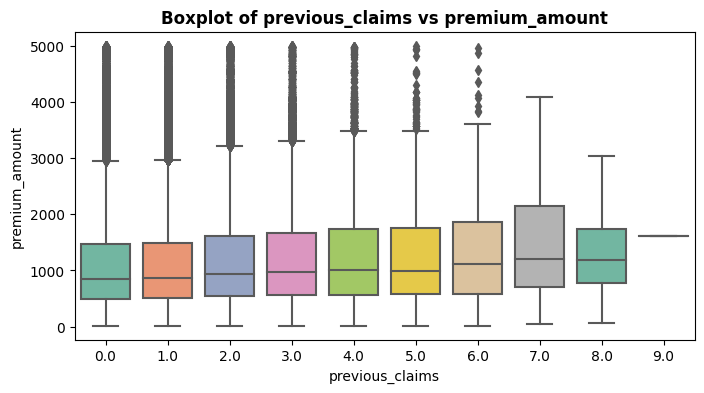

In [39]:
boxplot('previous_claims')

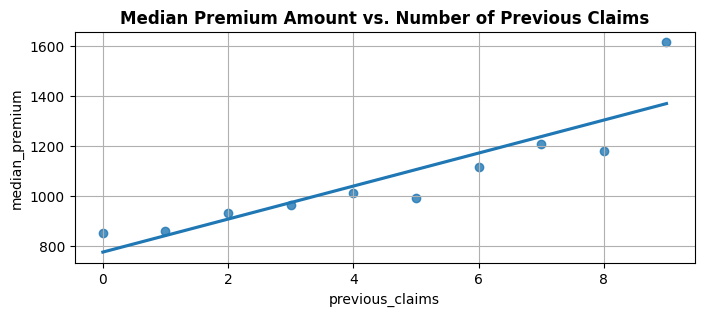

In [40]:
# Calculate medians for premium amounts grouped by previous_claims 
median_values = train_df.groupby('previous_claims')['premium_amount'].median().reset_index()

# Update data dictionary with these median values 
data = {'previous_claims': median_values['previous_claims'].tolist(), 
        'median_premium': median_values['premium_amount'].tolist()}

df = pd.DataFrame(data)

# Scatter plot with trend line 
plt.figure(figsize=(8, 3)) 
sns.regplot(data=df, x='previous_claims', y='median_premium', ci=None) 
plt.title('Median Premium Amount vs. Number of Previous Claims', 
          fontsize=12, weight='bold') 
plt.grid(True) 
plt.show() 

The scatterplot with a regression line indicates a generally positive trend between the **number of previous claims** and the **median premium amount**. This aligns with the expectation that individuals with more previous claims tend to have higher premiums. This observation supports the idea that insurers may increase premiums as the number of claims rises, likely due to the perceived risk associated with repeat claims.

Additionally, the plot shows a clear upward trend in the median premium as the number of previous claims increases. However, this trend becomes less reliable for higher claim counts, particularly for **previous_claims > 5.** This inconsistency may be attributed to the **presence of outliers** or **limited data** for higher claim counts.

## **Premium Amount by Occupation**

In [41]:
# Descriptive Statistics of `premium_amount` by `occupation`
train_df.groupby('occupation')['premium_amount'].describe()

,count,mean,std,min,25%,50%,75%,max
occupation,,,,,,,,
Employed,282750.00,1107.40,863.02,20.00,518.00,881.00,1515.00,4994.00
Self-Employed,282645.00,1106.61,870.25,20.00,514.00,874.00,1519.00,4988.00
Unemployed,276530.00,1105.37,868.46,20.00,514.00,874.00,1511.00,4997.00


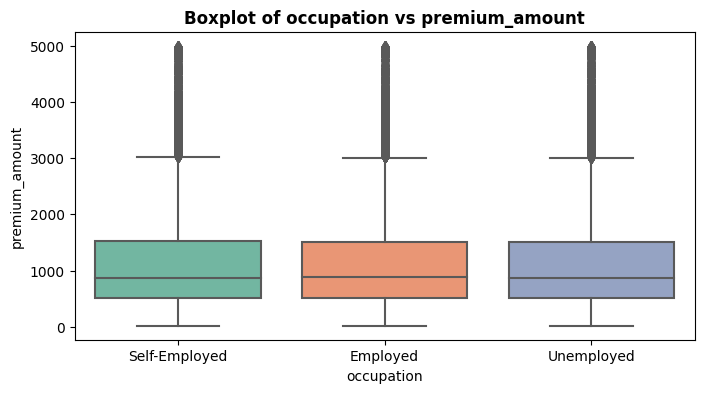

In [42]:
boxplot('occupation')

The **median premium amount** appears to be **roughly the same** for **Employed, Self-Employed**, and **Unemployed** policyholders. This suggests occupation does not significantly impact premiums. Similar spread indicate (Interquartile Range - IQR)  that the premium amounts are distributed similarly across all three groups, meaning there's **no distinct pattern linking occupation to large variations in premiums.** 

Boxplot indicates each category contains outliers (high premium amounts). While the dataset is synthetically generated, the presence of outliers aligns with expected trends in real-world insurance data, where extreme premium values often arise due to various risk-level factors.

## **Most Common Occupation by Income, Education, and Gender**

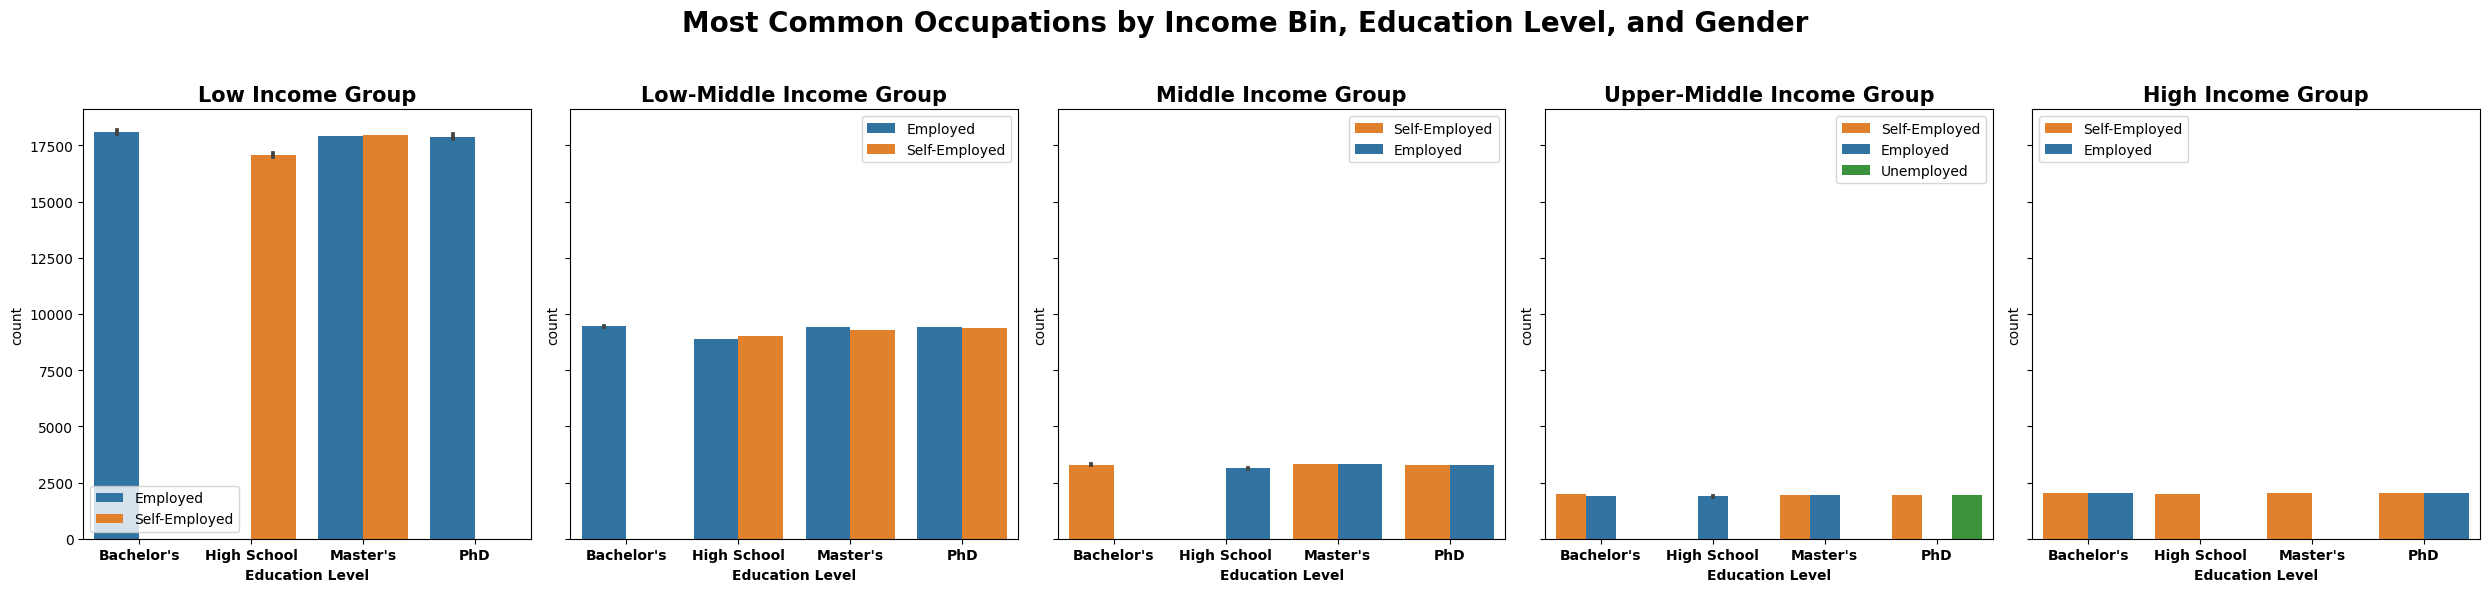

In [43]:
# Create income bins & label 
income_bins = [0, 25000, 50000, 75000, 100000, float('inf')]
income_labels = ['Low', 'Low-Middle', 'Middle', 'Upper-Middle', 'High']

# Create`income_bin`
train_df['income_bin'] = pd.cut(train_df['annual_income'], bins=income_bins,
                                  labels=income_labels, include_lowest=True)     

# Group by `income_bin`, `education_level`, and `occupation` & count occurrences
occupation_counts = train_df.groupby(
    ['income_bin', 'education_level', 'gender'])['occupation'].value_counts().reset_index(name='count')

# Find the mode for each group 
mode_occupation = occupation_counts.loc[occupation_counts.groupby(
    ['income_bin', 'education_level', 'gender'])['count'].idxmax()]

# List of unique income_bin
income_bins = mode_occupation['income_bin'].unique() 

# Define a custom color palette for occupations 
occupation_palette = { 'Employed': '#1f77b4', 'Self-Employed': '#ff7f0e', 'Unemployed': '#2ca02c'}

# Set up the plot size & title
fig, axes = plt.subplots(1, 5, figsize=(25, 6), sharey=True) 
fig.suptitle('Most Common Occupations by Income Bin, Education Level, and Gender', fontsize=20, weight='bold') 

# Plotting 
for i, income_bin in enumerate(income_bins):
    ax = axes[i] 
    subset = mode_occupation[mode_occupation['income_bin'] == income_bin] 
    sns.barplot(data=subset, x='education_level', y='count', palette=occupation_palette,
                hue='occupation', dodge=True, ax=ax) 
    ax.set_title(f'{income_bin} Income Group', size=15, weight='bold') 
    ax.set_xlabel('Education Level', fontdict=dict(weight='bold')) 
    ax.legend() 

    # Set the x-axis labels in bold
    for label in ax.get_xticklabels():
        label.set_weight('bold')
    
# Adjust layout 
plt.tight_layout(rect=[0, 0, 1, 0.95]) 
plt.show() 

The above plots display bar plots for each **income_bin**, showing the most common occupation for each combination of **education_level** and **gender**. Each education level contains two bars, one for each gender, colored differently based on the occupation. If both genders have the same occupation within the same education level and income bin, the bars will appear together (single bar). Otherwise, there will be two distinct bars indicating the occupations.

The above plots clearly show that our dataset has **significant variability in occupation distributions** across groups defined by **income_bin**, **education_level**, and **gender**. The plots indicate that the proportions of occupations differ not only by income level and education level but also by gender within those groups. 

While gender may not directly define occupation, it is relevant in the context of our dataset as it contributes to the observed variability in occupations within different income levels and education groups.

# **Model Construction**
## **Feature Creation**

There are several ordinal features, such as **`education_level`**, **`customer_feedback`**, and others, which can be meaningfully converted to numerical values due to their inherent order.

The **`create_features`** function generates row-wise interaction and ratio-based features, these do not rely on global dataset statistics. While these features are not at risk of causing data leakage, they are created inside the KFold loop because they depend on input features that may contain missing values. By imputing missing data within each fold first, we ensure that these derived features are based on clean and reliable inputs. 

In addition, we use a **`group_feature`** function to construct group-wise combinations, for example, combining **`previous_claims`** and **`number_of_dependents`**, which are then used for categorical target encoding. This approach is motivated by our earlier analysis showing that individual categorical features have **weak correlation** with the target variable. Grouping them might introduce more granularity and potentially providing additional predictive power to the model when used with **TargetEncoder**.

In [44]:
def oridinal(df):
    # Mapping for oridinal encoding
    policy_type_mapping = {'Basic': 1, 'Premium': 2, 'Comprehensive': 3}
    customer_feedback_mapping = {'Poor': 1, 'Average': 2, 'Good': 3}
    education_level_mapping = {'High School': 1, "Bachelor's": 2, "Master's": 3, 'PhD': 4}
    location_mapping = {'Rural': 1, 'Suburban': 2, 'Urban': 3}
    exercise_mapping = {'Rarely': 1, 'Monthly': 2, 'Weekly': 3, 'Daily': 4}
    
    df['policy_type_enco'] = df['policy_type'].map(policy_type_mapping)
    df['customer_feedback_enco'] = df['customer_feedback'].map(customer_feedback_mapping)
    df['education_level_enco'] = df['education_level'].map(education_level_mapping)
    df['location_enco'] = df['location'].map(location_mapping)
    df['exercise_enco'] = df['exercise_frequency'].map(exercise_mapping)   
    
    # Encode smoking status as binary
    df['smoking_enco'] = np.where(df['smoking_status'] == 'Yes', 1, 0).astype(int) 

# Apply to train_df & test_df
oridinal(train_df)
oridinal(test_df) 


numerical = numerical + ['year', 'month', 'policy_type_enco', 'customer_feedback_enco', 'previous_claim_te', 
                         'education_level_enco', 'location_enco', 'exercise_enco', 'smoking_enco', 'month_te', 
                         'year_te', 'number_of_dependents_te']

# Remove 'smoking_status' from the categorical list 
categorical.remove('smoking_status')   

In [45]:
# Create interaction and ratio-based features 
def create_features(df):   
    # Create Claim Frequency 
    df['claim_frequency'] = df['previous_claims'] / df['insurance_duration']
    # Create Policy Tenure Ratio
    df['policy_tenure_ratio'] = df['insurance_duration'] / df['age']
    # Create Claim Ratio per Year 
    df['claim_ratio_per_year'] = df['previous_claims'] / (df['insurance_duration'] / 12)
    # Create Credit Health Interaction
    df['credit_health_interaction'] = df['credit_score'] * df['health_score']
    # Create Claims to Income Ratio
    df['claims_to_income_ratio'] = (df['previous_claims'] / df['annual_income']) * 10000
    # Dependents to Income Ratio
    df['dependents_income_ratio'] = (df['number_of_dependents'] / df['annual_income']) * 10000
    # Claims per dependent
    df['claims_per_dependents'] = df['previous_claims'] / (df['number_of_dependents'] + 1)  
    return df

In [46]:
# Create group features - this will be used for categorical target encoding 
def group_feature(df):
    df['month_year'] = df['month'].astype(str) + '_' + df['year'].astype(str)
    df['previous_claims_dependents'] = df['previous_claims'].astype(str) + '_' + df['number_of_dependents'].astype(str)
    df['gender_education'] = df['gender'].astype(str) + '_' + df['education_level'].astype(str)
    df['gender_occupation'] = df['gender'].astype(str) + '_' + df['occupation'].astype(str)
    return df

categorical_2 = ['previous_claim_te', 'month_te', 'year_te', 'number_of_dependents_te', 
                 'month_year', 'previous_claims_dependents', 'gender_education', 'gender_occupation']  

In [47]:
# Covert data type to category from object
def change_type(df):
    for col in df.select_dtypes('object').columns:
        df[col] = df[col].astype('category')

change_type(train_df)
change_type(test_df)   

In [48]:
# Custom RMSLE 
def rmsle(y_true, y_pred):
    y_true_original = np.expm1(y_true)
    y_pred_original = np.expm1(y_pred)
    y_pred_original = np.maximum(y_pred_original, 0)
    return np.sqrt(mean_squared_log_error(y_true_original, y_pred_original))   

In [49]:
# Imputation 
num_imputer = SimpleImputer(strategy='median')
cat_imputer = SimpleImputer(strategy='most_frequent')

preprocessor = ColumnTransformer(transformers=[
    ('num', num_imputer, numerical),
    ('cat', cat_imputer, categorical)
])   

In [50]:
# Features & Target 
X = train_df.drop(columns=['premium_amount', 'policy_start_date', 'smoking_status'])
X['previous_claim_te'] = X['previous_claims']
X['month_te'] = X['month']
X['year_te'] = X['year']
X['number_of_dependents_te'] = X['number_of_dependents']

# Log Transform target variable
y = np.log1p(train_df['premium_amount'])

# Log Transform annual_income 
X['annual_income'] = np.log1p(X['annual_income'])

X_test = test_df.drop(columns=['id', 'policy_start_date', 'smoking_status'])   
X_test['previous_claim_te'] = X_test['previous_claims'] 
X_test['month_te'] = X_test['month']
X_test['year_te'] = X_test['year']      
X_test['number_of_dependents_te'] = X_test['number_of_dependents']

# Log Transform annual_income and health_score
X_test['annual_income'] = np.log1p(X_test['annual_income'])   

# Hyperparmeters 
params = {
    'n_estimators': 12000,
    'learning_rate': 0.01,
    'subsample': 0.75, 
    'colsample_bytree': 0.75,
    'reg_lambda': 0.3, 
    'reg_alpha': 0.3, 
    'num_leaves': 64, 
    'max_depth': 10, 
    'min_child_samples': 30, 
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'device': 'gpu',
    'random_state': 42
}         

In [51]:
X.shape, X_test.shape, y.shape   

((1200000, 30), (800000, 29), (1200000,))

In [52]:
# Initialize OOF arrays      
oof_preds = np.zeros(len(X))
test_preds = np.zeros(len(X_test))
rmsle_scores = []

kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Function for binned target encoding
def add_binned_target_encoding(df, df_list, target, features, q=100): 
    for feature in features:
        df[f'{feature}_bin'] = pd.qcut(df[feature], q=q, duplicates='drop')

        aggs = ['mean', 'median', 'min', 'max', 'skew', 'std', 'nunique']   
        stats = df.groupby(f'{feature}_bin')[target].agg(aggs).reset_index()
        stats.columns = [f'{feature}_bin'] + [f'{feature}_{agg}' for agg in aggs]

        bin_edges = df[f'{feature}_bin'].cat.categories

        for i, temp_df in enumerate(df_list):
            temp_df[f'{feature}_bin'] = pd.cut(temp_df[feature], bins=bin_edges, include_lowest=True)
            temp_df = temp_df.merge(stats, on=f'{feature}_bin', how='left')
            temp_df.drop(columns=[f'{feature}_bin'], inplace=True)
            df_list[i] = temp_df  # update in place

    return df_list

# KFold cross-validation
print('### Training LightGBM Model ###')
for fold, (train_idx, valid_idx) in enumerate(kf.split(X)):
    print(f"\n### Training Fold {fold+1} ###")

    # Train-valid Split 
    X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
    X_valid, y_valid = X.iloc[valid_idx], y.iloc[valid_idx]  
    
    # Impute missing values separately for train/val
    X_train = pd.DataFrame(preprocessor.fit_transform(X_train), columns = numerical + categorical)
    X_valid = pd.DataFrame(preprocessor.transform(X_valid), columns = numerical + categorical) 
    X_test = pd.DataFrame(preprocessor.transform(X_test), columns = numerical + categorical) 
    
    # All numeric features to remain numeric after imputation 
    X_train[numerical] = X_train[numerical].astype(float)
    X_valid[numerical] = X_valid[numerical].astype(float)
    X_test[numerical] = X_test[numerical].astype(float) 
    
    # Reset index before further processing
    X_train.reset_index(drop=True, inplace=True)
    X_valid.reset_index(drop=True, inplace=True)
    X_test.reset_index(drop=True, inplace=True)
    
    y_train = y_train.reset_index(drop=True)
    y_valid = y_valid.reset_index(drop=True)
    
    # Add new features (Interactions & Ratio-based)
    X_train = create_features(X_train)
    X_valid = create_features(X_valid)  
    X_test = create_features(X_test)

    # Add group-wise features
    X_train = group_feature(X_train)
    X_valid = group_feature(X_valid)  
    X_test = group_feature(X_test)
    
    # Credit_score
    Xy_train = X_train.copy()
    Xy_train['premium_amount'] = y_train        
    aggs = ['mean', 'median', 'min', 'max', 'skew', 'std', 'nunique']   
    credit_score_stats = Xy_train.groupby('credit_score')['premium_amount'].agg(aggs)
    credit_score_stats.columns = [f'credit_score_{agg}' for agg in aggs]
    credit_score_stats.reset_index(inplace=True)   
    
    # Merge Aggregated Features into Train, Validation, and Test
    X_train = X_train.merge(credit_score_stats , on='credit_score', how='left')
    X_valid = X_valid.merge(credit_score_stats , on='credit_score', how='left')
    X_test = X_test.merge(credit_score_stats , on='credit_score', how='left')  

    # Average Claims Per Policy Type 
    claims_per_policy_type = Xy_train.groupby('policy_type')['previous_claims'].agg('mean').reset_index()
    claims_per_policy_type.columns = ['policy_type'] + ['claims_per_policy_type_mean']    

    # Merge Aggregated Features into Train, Validation, and Test
    X_train = X_train.merge(claims_per_policy_type, on='policy_type', how='left')
    X_valid = X_valid.merge(claims_per_policy_type, on='policy_type', how='left')
    X_test = X_test.merge(claims_per_policy_type, on='policy_type', how='left')

    # Risk Profile Index 
    risk_profile_index = Xy_train.groupby(['education_level', 'occupation', 'property_type'])['premium_amount'].agg(aggs).reset_index()
    risk_profile_index.columns = ['education_level', 'occupation', 'property_type'] + [f'risk_profile_index_{agg}' for agg in aggs]
    
    # Merge Aggregated Features into Train, Validation, and Test
    X_train = X_train.merge(risk_profile_index, on=['education_level', 'occupation', 'property_type'], how='left')
    X_valid = X_valid.merge(risk_profile_index, on=['education_level', 'occupation', 'property_type'], how='left')
    X_test = X_test.merge(risk_profile_index, on=['education_level', 'occupation', 'property_type'], how='left')
       
    # annual_income & health_score target encoding
    features = ['health_score', 'annual_income']
    X_train, X_valid, X_test = add_binned_target_encoding(
        df=Xy_train,
        df_list=[X_train, X_valid, X_test],
        target='premium_amount',
        features=features)  
      
    # Categorical Target Encoding 
    enco_cat = categorical + categorical_2    
    te = TargetEncoder(cols=enco_cat, smoothing=10)
    X_train = te.fit_transform(X_train, y_train)
    X_valid = te.transform(X_valid)
    X_test = te.transform(X_test)   

    # Fill NaNs in each of these newly aggregated columns with its median (based on train data only)
    agg_cols = [col for col in X_train.columns if any(
        stat in col for stat in ['mean', 'median', 'min', 'max', 'skew', 'std', 'nunique'])]  

    # Fill NaNs in each of these columns with its median (based on train data only)
    for col in agg_cols:  
      median_val = X_train[col].median()
      X_train[col].fillna(median_val, inplace=True)
      X_valid[col].fillna(median_val, inplace=True)
      X_test[col].fillna(median_val, inplace=True)
    
    # Training LightGBM Model
    model = LGBMRegressor(**params, verbose=-1)
    model.fit(
    X_train, y_train,
    eval_set=[(X_valid, y_valid)],
    eval_metric='rmse',
    callbacks=[early_stopping(stopping_rounds=50, verbose=False)])

    # Predict on validation & test set (in log space)
    y_valid_pred_log = model.predict(X_valid) 
    oof_preds[valid_idx] = y_valid_pred_log
    test_preds += model.predict(X_test) / kf.n_splits

    # Fold RMSLE
    fold_rmsle = rmsle(y_valid, y_valid_pred_log)
    print(f'LightGBM Fold {fold + 1} RMSLE: {fold_rmsle:.5f}')
    rmsle_scores.append(fold_rmsle)

final_oof_rmsle = rmsle(y, oof_preds) 
print(f'\nMean Fold-wise LightGBM RMSLE: {np.mean(rmsle_scores):.5f}') 
print(f'LightGBM OOF RMSLE on full training set: {final_oof_rmsle:.5f}')   

print(f"\nTotal number of features used: {X_train.shape[1]}")
print('Features used:\n', X_train.columns)                       

### Training LightGBM Model ###

### Training Fold 1 ###


1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.


LightGBM Fold 1 RMSLE: 1.05218

### Training Fold 2 ###
LightGBM Fold 2 RMSLE: 1.05102

### Training Fold 3 ###
LightGBM Fold 3 RMSLE: 1.05165

### Training Fold 4 ###
LightGBM Fold 4 RMSLE: 1.04964

### Training Fold 5 ###
LightGBM Fold 5 RMSLE: 1.05163

Mean Fold-wise LightGBM RMSLE: 1.05122
LightGBM OOF RMSLE on full training set: 1.05122

Total number of features used: 69
Features used:
 Index(['age', 'annual_income', 'number_of_dependents', 'health_score',
       'previous_claims', 'vehicle_age', 'credit_score', 'insurance_duration',
       'year', 'month', 'policy_type_enco', 'customer_feedback_enco',
       'previous_claim_te', 'education_level_enco', 'location_enco',
       'exercise_enco', 'smoking_enco', 'month_te', 'year_te',
       'number_of_dependents_te', 'gender', 'marital_status',
       'education_level', 'occupation', 'location', 'policy_type',
       'customer_feedback', 'exercise_frequency', 'property_type',
       'claim_frequency', 'policy_tenure_ratio', 'claim_r

## **Feature Transformation and Encoding Strategy**

### **Log Transformation for Skewed Distributions:**

The target variable, **`premium_amount`**, exhibited a **right-skewed distribution** with **outliers**, which could negatively impact the **Root Mean Squared Logarithmic Error (RMSLE)** metric, as **RMSLE** is not robust to extreme values. To mitigate this, I applied a **log transformation to `premium_amount`** to reduce skewness and stabilize variance.

Similarly, **`annual_income`** had a wide range with **significant outliers**. Since these values could be genuine, rather than removing them, I log-transformed **`annual_income`** to make the distribution more manageable while preserving all data points. 

### **Target Encoding of Categorical and Group-wise Features**
The boxplots showed consistent shapes and sizes, with similar or identical means, medians, and interquartile ranges (IQR) across categories, indicating limited variation in the target variable among the categorical groups. This suggests that individual categorical features **offer weak standalone predictive power.**

To address this, I applied target encoding to both **single categorical** variables and **engineered group-wise combinations**, such as **month + year** and **occupation + gender**. These combinations were created to introduce more granular patterns and uncover interactions that individual features may not capture, potentially reflecting **subtle socio-demographic** or **temporal effects** on premium pricing.

All target encoding was performed within each fold of cross-validation to prevent data leakage and preserve validation integrity. This approach might help the model learn **category-to-target relationships** more effectively.

### **Target Encoding of Low-Signal Numeric Features:**

While features like **`previous_claims`**, **`month`**, **`year`**, and **`number_of_dependents`** individually showed weak correlation with the target variable, **`previous_claims`** displayed a **clear upward trend** in **median premium amount** up to a certain range (specifically for **claims ≤ 4**).

To retain the original signal and extract additional patterns, I created duplicate columns for these variables and applied target encoding to the copies, preserving the raw versions as well.

In [53]:
# Check unique credit score
print(train_df['credit_score'].nunique())

train_credit = train_df['credit_score'].dropna().unique().tolist()
test_credit = test_df['credit_score'].dropna().unique().tolist()

set(train_credit) == set(test_credit)

550


True

### **Aggregated Features from Credit Scores:**
The **`credit_score`** feature contained approximately **550** unique values, which were consistently present in both the training and test sets, ensuring stable representation across datasets. Despite its **high cardinality**, the large training set of **1.2 million** samples made it viable to leverage this feature for meaningful signal extraction.

To capture patterns linked to **`credit_score`**, I computed **statistical aggregations** (mean, median, min, max, standard deviation, etc.) of the log-transformed **`premium_amount`**, grouped by **`credit_score`**. These aggregated features were intended to enrich the model's understanding of **credit-related trends** in premium pricing. To prevent data leakage, all aggregations were computed within each fold during cross-validation.

### **Encoding High-Cardinality Numerical Features:**
Features like **`annual_income`** and **`health_score`** exhibited ***too high cardinality*** for direct target encoding to be effective, as this would result in sparse and potentially noisy representations. To overcome this, I **binned these features into 100 percentile-based groups** to reduce cardinality while retaining distributional context. Target encoding and statistical aggregations (mean, median, standard deviation, etc.) of the log-transformed target variable were then computed on these bins within each fold to prevent data leakage.

# **Feature Importance**

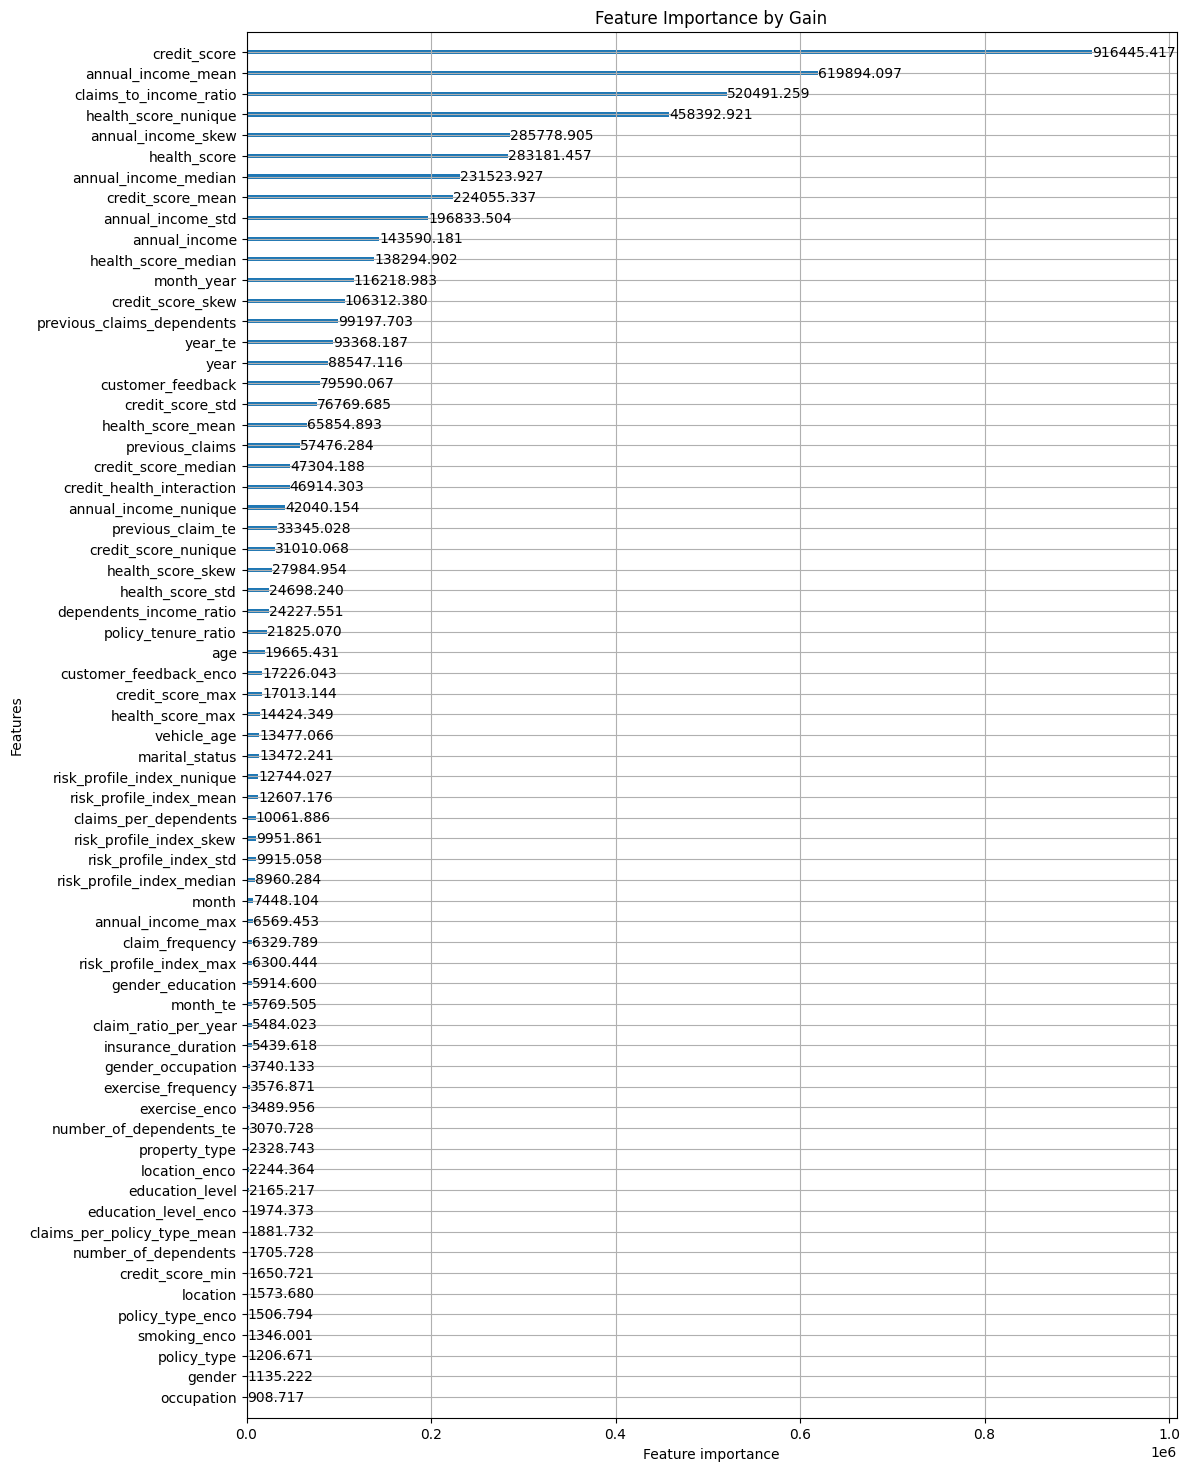

In [54]:
# Plot Feature Importance (gain)
lgb.plot_importance(model.booster_, importance_type = 'gain', figsize=(12, 18))
plt.title('Feature Importance by Gain');

# **Predicting on the Test Dataset**

In [55]:
# Converting log predictions back to original values
y_test_pred = np.expm1(test_preds)    

In [56]:
# Ensure no negative predictions
y_test_pred = np.maximum(y_test_pred, 0)

# Create the submission DataFrame
submission = pd.DataFrame({
    'id': test_df['id'],
    'Premium Amount': y_test_pred
})

# Save the submission file
submission.to_csv('submission.csv', index=False)
print("Final submission file created")

Final submission file created


In [57]:
submission.head()   

,id,Premium Amount
0,1200000,626.69
1,1200001,857.21
2,1200002,844.20
3,1200003,721.09
4,1200004,687.75
